<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintIIa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint I: Análise de Dados e Boas Práticas (40530010055_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Maio/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS).

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

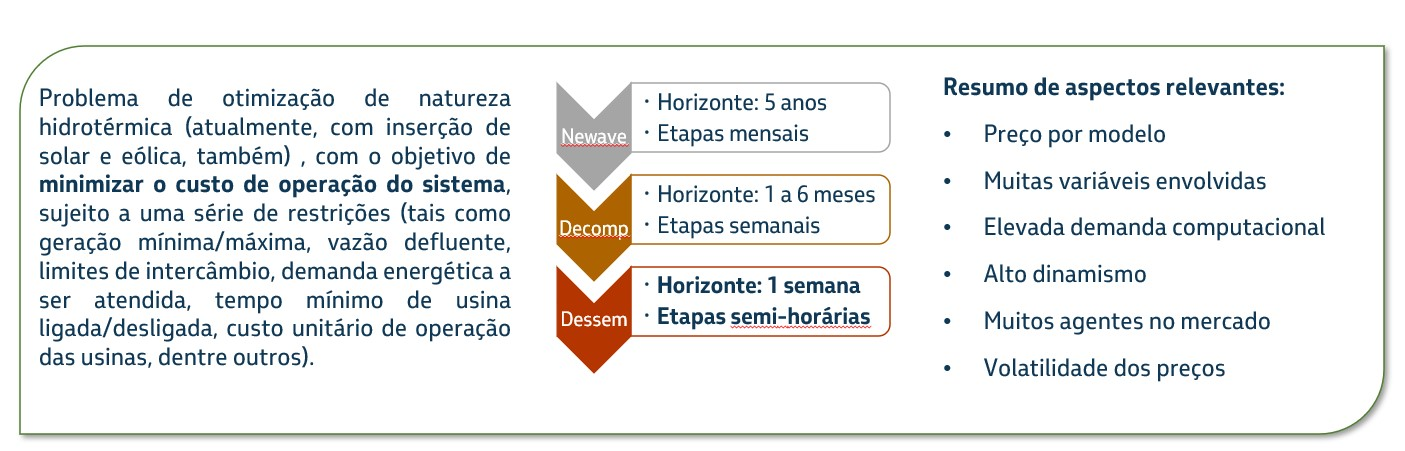

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

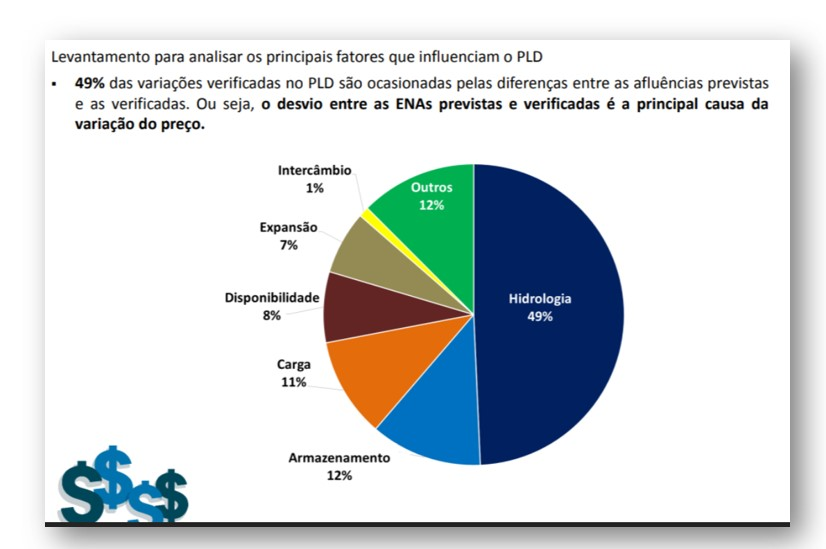

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [445]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#
## Transformações Numéricas e ML
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
#
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [446]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-07-01 17:47:33.007196
2023


In [447]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
735            SE        SUDESTE  2023-07-03            24380.398438   
736             N          NORTE  2023-07-04             5264.079102   
737            NE       NORDESTE  2023-07-04             2255.814941   
738             S            SUL  2023-07-04             5201.711914   
739            SE        SUDESTE  2023-07-04            23955.962891   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [448]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [449]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
730             S            SUL  2023-07-02             6054.736816   
731            SE        SUDESTE  2023-07-02            24945.392578   
732             N          NORTE  2023-07-03             5331.175781   
733            NE       NORDESTE  2023-07-03             2258.552002   
734             S            SUL  2023-07-03             5576.879883   
735            SE        SUDESTE  2023-07-03            24380.398438   
736             N          NORTE  2023-07-04             5264.079102   
737            NE       NORDESTE  2023-07-04             2255.814941   
738             S            SUL  2023-07-04             5201.711914   
739            SE        SUDESTE  2023-07-04            23955.962891   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
730                       55.376099                   5880.907227   
731                       97.272903                  24039.927734   
732                      101.337997                   5105.820801   
733                       59.828800                   2235.672119   
734                       51.005600                   5517.502930   
735                       95.069801                  24113.210938   
736                      100.062500                   5016.908203   
737                       59.756302                   2235.794922   
738                       47.574402                   5095.515137   
739                       93.414703                  23458.638672   

     ena_armazenavel_regiao_percentualmlt  
730                             53.786201  
731                             93.742104  
732                             97.054298  
733                             59.222698  
734                             50.462601  
735                             94.027901  
736                             95.364197  
737                             59.225899  
738                             46.603100  
739                             91.475403

In [450]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8220.0

In [451]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [452]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [453]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
735            SE        Sudeste  2023-07-03            24380.398438   
736             N          Norte  2023-07-04             5264.079102   
737            NE       Nordeste  2023-07-04             2255.814941   
738             S            Sul  2023-07-04             5201.711914   
739            SE        Sudeste  2023-07-04            23955.962891   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [454]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [455]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [456]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
739            SE        Sudeste 2023-07-04            23955.962891   
738             S            Sul 2023-07-04             5201.711914   
737            NE       Nordeste 2023-07-04             2255.814941   
736             N          Norte 2023-07-04             5264.079102   
735            SE        Sudeste 2023-07-03            24380.398438   
734             S            Sul 2023-07-03             5576.879883   
733            NE       Nordeste 2023-07-03             2258.552002   
732             N          Norte 2023-07-03             5331.175781   
729            NE       Nordeste 2023-07-02             2256.830078   
728             N          Norte 2023-07-02             5413.121094   
731            SE        Sudeste 2023-07-02            24945.392578   
730             S            Sul 2023-07-02             6054.736816   
727            SE        Sudeste 2023-07-01            25529.462891   
726             S            Sul 2023-07-01             6667.686035   
725            NE       Nordeste 2023-07-01             2253.669922   
724             N          Norte 2023-07-01             5493.669922   
721            NE       Nordeste 2023-06-30             2253.306885   
720             N          Norte 2023-06-30             5588.012207   
723            SE        Sudeste 2023-06-30            26182.804688   
722             S            Sul 2023-06-30             7526.895996   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
739                       93.414703                  23458.638672   
738                       47.574402                   5095.515137   
737                       59.756302                   2235.794922   
736                      100.062500                   5016.908203   
735                       95.069801                  24113.210938   
734                       51.005600                   5517.502930   
733                       59.828800                   2235.672119   
732                      101.337997                   5105.820801   
729                       59.783199                   2232.520020   
728                      102.895599                   5157.693848   
731                       97.272903                  24039.927734   
730                       55.376099                   5880.907227   
727                       99.550499                  25095.740234   
726                       60.981998                   6604.064941   
725                       59.699402                   2244.375000   
724                      104.426697                   5279.109863   
721                       49.223301                   2253.306885   
720                       52.150799                   5411.187988   
723                       80.388100                  25901.169922   
722                       72.058601                   7425.387207   

     ena_armazenavel_regiao_percentualmlt  
739                             91.475403  
738                             46.603100  
737                             59.225899  
736                             95.364197  
735                             94.027901  
734                             50.462601  
733                             59.222698  
732                             97.054298  
729                             59.139198  
728                             98.040298  
731                             93.742104  
730                             53.786201  
727                             97.859200  
726                             60.400200  
725                             59.453201  
724                            100.348297  
721                             49.223301  
720                             50.500599  
723                             79.523399  
722                             71.086800

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [457]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
735             S            SUL  2023-07-03        20459.242188   
736            NE       NORDESTE  2023-07-04        51691.226562   
737             N          NORTE  2023-07-04        15302.396484   
738            SE        SUDESTE  2023-07-04       204615.328125   
739             S            SUL  2023-07-04        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [458]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [459]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
730            SE        SUDESTE  2023-07-02       204615.328125   
731             S            SUL  2023-07-02        20459.242188   
732            NE       NORDESTE  2023-07-03        51691.226562   
733             N          NORTE  2023-07-03        15302.396484   
734            SE        SUDESTE  2023-07-03       204615.328125   
735             S            SUL  2023-07-03        20459.242188   
736            NE       NORDESTE  2023-07-04        51691.226562   
737             N          NORTE  2023-07-04        15302.396484   
738            SE        SUDESTE  2023-07-04       204615.328125   
739             S            SUL  2023-07-04        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
730               176603.656250                        86.310097  
731                18076.369141                        88.353104  
732                43667.968750                        84.478500  
733                14874.619141                        97.204498  
734               176453.515625                        86.236702  
735                17980.251953                        87.883301  
736                43589.652344                        84.327003  
737                14855.998047                        97.082802  
738               176390.343750                        86.205803  
739                17992.878906                        87.945000

In [460]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8220.0

In [461]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [462]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [463]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
735             S            Sul  2023-07-03        20459.242188   
736            NE       Nordeste  2023-07-04        51691.226562   
737             N          Norte  2023-07-04        15302.396484   
738            SE        Sudeste  2023-07-04       204615.328125   
739             S            Sul  2023-07-04        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [464]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [465]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [466]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
739             S            Sul 2023-07-04        20459.242188   
738            SE        Sudeste 2023-07-04       204615.328125   
737             N          Norte 2023-07-04        15302.396484   
736            NE       Nordeste 2023-07-04        51691.226562   
735             S            Sul 2023-07-03        20459.242188   
734            SE        Sudeste 2023-07-03       204615.328125   
733             N          Norte 2023-07-03        15302.396484   
732            NE       Nordeste 2023-07-03        51691.226562   
729             N          Norte 2023-07-02        15302.396484   
728            NE       Nordeste 2023-07-02        51691.226562   
731             S            Sul 2023-07-02        20459.242188   
730            SE        Sudeste 2023-07-02       204615.328125   
727             S            Sul 2023-07-01        20459.242188   
726            SE        Sudeste 2023-07-01       204615.328125   
725             N          Norte 2023-07-01        15302.396484   
724            NE       Nordeste 2023-07-01        51691.226562   
721             N          Norte 2023-06-30        15302.396484   
720            NE       Nordeste 2023-06-30        51691.226562   
723             S            Sul 2023-06-30        20459.242188   
722            SE        Sudeste 2023-06-30       204615.328125   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
739                17992.878906                        87.945000  
738               176390.343750                        86.205803  
737                14855.998047                        97.082802  
736                43589.652344                        84.327003  
735                17980.251953                        87.883301  
734               176453.515625                        86.236702  
733                14874.619141                        97.204498  
732                43667.968750                        84.478500  
729                14917.297852                        97.483398  
728                43731.527344                        84.601402  
731                18076.369141                        88.353104  
730               176603.656250                        86.310097  
727                18090.408203                        88.421700  
726               176661.453125                        86.338303  
725                14962.058594                        97.775902  
724                43783.894531                        84.702797  
721                15005.811523                        98.061798  
720                43838.820312                        84.808998  
723                18072.357422                        88.333504  
722               176747.578125                        86.380402

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [467]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
735            SE  Sudeste/Centro-Oeste   2023-07-03           37691.382333
736             N                 Norte   2023-07-04            7283.209958
737            NE              Nordeste   2023-07-04           11820.499208
738             S                   Sul   2023-07-04           12745.532083
739            SE  Sudeste/Centro-Oeste   2023-07-04           38575.936333

[32881 rows x 4 columns]


In [468]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [469]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
730             S                   Sul   2023-07-02            9695.054542
731            SE  Sudeste/Centro-Oeste   2023-07-02           33093.944333
732             N                 Norte   2023-07-03            7240.587375
733            NE              Nordeste   2023-07-03           11504.037000
734             S                   Sul   2023-07-03           12326.182083
735            SE  Sudeste/Centro-Oeste   2023-07-03           37691.382333
736             N                 Norte   2023-07-04            7283.209958
737            NE              Nordeste   2023-07-04           11820.499208
738             S                   Sul   2023-07-04           12745.532083
739            SE  Sudeste/Centro-Oeste   2023-07-04           38575.936333

In [470]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8220.25

In [471]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [472]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [473]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [474]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
735            SE        Sudeste  2023-07-03           37691.382333
736             N          Norte  2023-07-04            7283.209958
737            NE       Nordeste  2023-07-04           11820.499208
738             S            Sul  2023-07-04           12745.532083
739            SE        Sudeste  2023-07-04           38575.936333

[32881 rows x 4 columns]


In [475]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [476]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [477]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
739            SE        Sudeste 2023-07-04           38575.936333
738             S            Sul 2023-07-04           12745.532083
737            NE       Nordeste 2023-07-04           11820.499208
736             N          Norte 2023-07-04            7283.209958
735            SE        Sudeste 2023-07-03           37691.382333
734             S            Sul 2023-07-03           12326.182083
733            NE       Nordeste 2023-07-03           11504.037000
732             N          Norte 2023-07-03            7240.587375
729            NE       Nordeste 2023-07-02           10533.034625
728             N          Norte 2023-07-02            6734.179167
731            SE        Sudeste 2023-07-02           33093.944333
730             S            Sul 2023-07-02            9695.054542
727            SE        Sudeste 2023-07-01           36323.087000
726             S            Sul 2023-07-01           10884.159083
725            NE       Nordeste 2023-07-01           11330.473000
724             N          Norte 2023-07-01            7034.300542
721            NE       Nordeste 2023-06-30           11814.919875
720             N          Norte 2023-06-30            7287.393083
723            SE        Sudeste 2023-06-30           39616.549375
722             S            Sul 2023-06-30           12594.559917

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível.




In [478]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

    id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0               N          NORTE   2005-01-07                 0.94   
1              NE       NORDESTE   2005-01-07                 0.94   
2               S            SUL   2005-01-07                 4.50   
3              SE        SUDESTE   2005-01-07                 0.00   
4               N          NORTE   2005-01-14                 6.34   
..            ...            ...          ...                  ...   
103            SE        SUDESTE   2023-06-30                 0.00   
104             N          NORTE   2023-07-07                 0.00   
105            NE       NORDESTE   2023-07-07                 0.00   
106             S            SUL   2023-07-07                 0.00   
107            SE        SUDESTE   2023-07-07                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.3

In [479]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [480]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
98              S            SUL   2023-06-23                  0.0   
99             SE        SUDESTE   2023-06-23                  0.0   
100             N          NORTE   2023-06-30                  0.0   
101            NE       NORDESTE   2023-06-30                  0.0   
102             S            SUL   2023-06-30                  0.0   
103            SE        SUDESTE   2023-06-30                  0.0   
104             N          NORTE   2023-07-07                  0.0   
105            NE       NORDESTE   2023-07-07                  0.0   
106             S            SUL   2023-07-07                  0.0   
107            SE        SUDESTE   2023-07-07                  0.0   

     val_cmoleve  val_cmomedia  val_cmopesada  
98           0.0           0.0            0.0  
99           0.0           0.0            0.0  
100          0.0           0.0            0.0  
101          0.0           0.0            0.0  
102          0.0           0.0            0.0  
103          0.0           0.0            0.0  
104          0.0           0.0            0.0  
105          0.0           0.0            0.0  
106          0.0           0.0            0.0  
107          0.0           0.0            0.0

In [481]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [482]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

    id_subsistema nom_subsistema        Data  val_cmomediasemanal  \
0               N          Norte  2005-01-07                 0.94   
1              NE       Nordeste  2005-01-07                 0.94   
2               S            Sul  2005-01-07                 4.50   
3              SE        Sudeste  2005-01-07                 0.00   
4               N          Norte  2005-01-14                 6.34   
..            ...            ...         ...                  ...   
103            SE        Sudeste  2023-06-30                 0.00   
104             N          Norte  2023-07-07                 0.00   
105            NE       Nordeste  2023-07-07                 0.00   
106             S            Sul  2023-07-07                 0.00   
107            SE        Sudeste  2023-07-07                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.39          4

In [483]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [484]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [485]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                  0.0          0.0   
106             S            Sul 2023-07-07                  0.0          0.0   
105            NE       Nordeste 2023-07-07                  0.0          0.0   
104             N          Norte 2023-07-07                  0.0          0.0   
103            SE        Sudeste 2023-06-30                  0.0          0.0   
102             S            Sul 2023-06-30                  0.0          0.0   
101            NE       Nordeste 2023-06-30                  0.0          0.0   
100             N          Norte 2023-06-30                  0.0          0.0   
99             SE        Sudeste 2023-06-23                  0.0          0.0   
98              S            Sul 2023-06-23                  0.0          0.0   
97             NE       Nordeste 2023-06-23                  0.0          0.0   
96              N          Norte 2023-06-23                  0.0          0.0   
94              S            Sul 2023-06-16                  0.0          0.0   
92              N          Norte 2023-06-16                  0.0          0.0   
93             NE       Nordeste 2023-06-16                  0.0          0.0   
95             SE        Sudeste 2023-06-16                  0.0          0.0   
91             SE        Sudeste 2023-06-09                  0.0          0.0   
90              S            Sul 2023-06-09                  0.0          0.0   
89             NE       Nordeste 2023-06-09                  0.0          0.0   
88              N          Norte 2023-06-09                  0.0          0.0   

     val_cmomedia  val_cmopesada  
107           0.0            0.0  
106           0.0            0.0  
105           0.0            0.0  
104           0.0            0.0  
103           0.0            0.0  
102           0.0            0.0  
101           0.0            0.0  
100           0.0            0.0  
99            0.0            0.0  
98            0.0            0.0  
97            0.0            0.0  
96            0.0            0.0  
94            0.0            0.0  
92            0.0            0.0  
93            0.0            0.0  
95            0.0            0.0  
91            0.0            0.0  
90            0.0            0.0  
89            0.0            0.0  
88            0.0            0.0

In [486]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                 0.00         0.00   
106             S            Sul 2023-07-07                 0.00         0.00   
105            NE       Nordeste 2023-07-07                 0.00         0.00   
104             N          Norte 2023-07-07                 0.00         0.00   
103            SE        Sudeste 2023-06-30                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [487]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [488]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-07                 0.00         0.00   
106             S            Sul 2023-07-07                 0.00         0.00   
105            NE       Nordeste 2023-07-07                 0.00         0.00   
104             N          Norte 2023-07-07                 0.00         0.00   
103            SE        Sudeste 2023-06-30                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [489]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
126             S            Sul 2011-08-12                10.06         0.00   
84              N          Norte 2008-05-30                27.60         0.00   
162             S            Sul 2014-10-10               429.10         0.00   
19             SE        Sudeste 2012-02-03                12.91         0.00   
18              S            Sul 2012-02-03                12.91         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
126         15.70          16.26          0  1.000000  
84          43.31          43.43          0  1.000000  
162        673.73         673.73          0  1.000000  
19          20.27          20.27          0  1.000000  
18          20.27          20.27          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada.



In [490]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
107            SE        Sudeste 2023-07-01                 0.00         0.00   
106             S            Sul 2023-07-01                 0.00         0.00   
105            NE       Nordeste 2023-07-01                 0.00         0.00   
104             N          Norte 2023-07-01                 0.00         0.00   
103            SE        Sudeste 2023-06-24                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
6               S            Sul 2005-01-08                12.32        12.11   
2               S            Sul 2005-01-01                 4.50         4.39   
3              SE        Sudeste 2005-01-01                 0.00         0.00   
1              NE       Nordeste 2005-01-01                 0.94         0.94   
0               N          Norte 2005-01-01                 0.94         0.94   

     val_cmomedia  val_cmop

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [491]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-04            23955.962891   
1                 S            Sul 2023-07-04             5201.711914   
2                NE       Nordeste 2023-07-04             2255.814941   
3                 N          Norte 2023-07-04             5264.079102   
4                SE        Sudeste 2023-07-03            24380.398438   
...             ...            ...        ...                     ...   
32875            SE        Sudeste 2001-01-02            41230.000000   
32876             S            Sul 2001-01-01             7703.000000   
32877            NE       Nordeste 2001-01-01            13472.000000   
32878            SE        Sudeste 2001-01-01            39186.000000   
32879             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.414703               

In [492]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-04            23955.962891   
1                 S            Sul 2023-07-04             5201.711914   
2                NE       Nordeste 2023-07-04             2255.814941   
3                 N          Norte 2023-07-04             5264.079102   
4                SE        Sudeste 2023-07-03            24380.398438   
...             ...            ...        ...                     ...   
32875            SE        Sudeste 2001-01-02            41230.000000   
32876             S            Sul 2001-01-01             7703.000000   
32877            NE       Nordeste 2001-01-01            13472.000000   
32878            SE        Sudeste 2001-01-01            39186.000000   
32879             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.414703               

In [493]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-04            23955.962891   
1                 S            Sul 2023-07-04             5201.711914   
2                NE       Nordeste 2023-07-04             2255.814941   
3                 N          Norte 2023-07-04             5264.079102   
4                SE        Sudeste 2023-07-03            24380.398438   
...             ...            ...        ...                     ...   
32875            SE        Sudeste 2001-01-02            41230.000000   
32876             S            Sul 2001-01-01             7703.000000   
32877            NE       Nordeste 2001-01-01            13472.000000   
32878            SE        Sudeste 2001-01-01            39186.000000   
32879             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.414703               

In [494]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-07-04            23955.962891   
1                Sul 2023-07-04             5201.711914   
2           Nordeste 2023-07-04             2255.814941   
3              Norte 2023-07-04             5264.079102   
4            Sudeste 2023-07-03            24380.398438   
...              ...        ...                     ...   
32875        Sudeste 2001-01-02            41230.000000   
32876            Sul 2001-01-01             7703.000000   
32877       Nordeste 2001-01-01            13472.000000   
32878        Sudeste 2001-01-01            39186.000000   
32879          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           93.414703                  23458.638672   
1                           47.574402                   5095.515137   
2                           59.756302                   2235.794922   
3      

In [495]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-04      23955.962891        93.414703   
1            Sul 2023-07-04       5201.711914        47.574402   
2       Nordeste 2023-07-04       2255.814941        59.756302   
3          Norte 2023-07-04       5264.079102       100.062500   
4        Sudeste 2023-07-03      24380.398438        95.069801   
...          ...        ...               ...              ...   
32875    Sudeste 2001-01-02      41230.000000        91.519997   
32876        Sul 2001-01-01       7703.000000       160.910004   
32877   Nordeste 2001-01-01      13472.000000       101.480003   
32878    Sudeste 2001-01-01      39186.000000        86.980003   
32879      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23458.638672              91.475403  204615.328125   
1                 5095.515137              46.603100   20459.2421

In [496]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-04      23955.962891        93.414703   
1            Sul 2023-07-04       5201.711914        47.574402   
2       Nordeste 2023-07-04       2255.814941        59.756302   
3          Norte 2023-07-04       5264.079102       100.062500   
4        Sudeste 2023-07-03      24380.398438        95.069801   
...          ...        ...               ...              ...   
32875    Sudeste 2001-01-02      41230.000000        91.519997   
32876        Sul 2001-01-01       7703.000000       160.910004   
32877   Nordeste 2001-01-01      13472.000000       101.480003   
32878    Sudeste 2001-01-01      39186.000000        86.980003   
32879      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23458.638672              91.475403  204615.328125   
1                 509

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [497]:
# Mostrando as dimensões do dataset
dados.shape

(32880, 16)

In [498]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32880 entries, 0 to 32879
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32880 non-null  object        
 1   Data                    32880 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32880 non-null  float64       
 3   ENA_Bruta[%MLT]         32880 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32880 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32880 non-null  float64       
 6   EAR_max                 32880 non-null  float64       
 7   EAR[MWmes]              32880 non-null  float64       
 8   EAR[%max]               32880 non-null  float64       
 9   Carga_Diaria[MWmed]     32832 non-null  float64       
 10  CMO_semanal[R$/MWh]     3864 non-null   float64       
 11  CMO_leve[R$/MWh]        3864 non-null   float64       
 12  CMO_media[R$/MWh]       3864 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [499]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-04      23955.962891        93.414703   
1            Sul 2023-07-04       5201.711914        47.574402   
2       Nordeste 2023-07-04       2255.814941        59.756302   
3          Norte 2023-07-04       5264.079102       100.062500   
4        Sudeste 2023-07-03      24380.398438        95.069801   
...          ...        ...               ...              ...   
27031    Sudeste 2005-01-02      43352.000000        86.129997   
27032    Sudeste 2005-01-01      43952.000000        87.320000   
27033        Sul 2005-01-01       2812.000000        50.650002   
27034   Nordeste 2005-01-01      10222.000000        74.010002   
27035      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23458.638672              91.475403  204615.328125   
1                 5095.515137              46.603100   20459.2421

In [500]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-04      23955.962891        93.414703   
1            Sul 2023-07-04       5201.711914        47.574402   
2       Nordeste 2023-07-04       2255.814941        59.756302   
3          Norte 2023-07-04       5264.079102       100.062500   
4        Sudeste 2023-07-03      24380.398438        95.069801   
...          ...        ...               ...              ...   
27031    Sudeste 2005-01-02      43352.000000        86.129997   
27032    Sudeste 2005-01-01      43952.000000        87.320000   
27033        Sul 2005-01-01       2812.000000        50.650002   
27034   Nordeste 2005-01-01      10222.000000        74.010002   
27035      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23458.638672              91.475403  204615.328125   
1                 5095.515137              46.603100   20459.2421

In [501]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-07-04       5201.711914        47.574402   
5         Sul 2023-07-03       5576.879883        51.005600   
11        Sul 2023-07-02       6054.736816        55.376099   
13        Sul 2023-07-01       6667.686035        60.981998   
19        Sul 2023-06-30       7526.895996        72.058601   
21        Sul 2023-06-29       8970.545898        85.879402   
25        Sul 2023-06-28      10489.100586       100.417198   
29        Sul 2023-06-27      12598.967773       120.615997   
35        Sul 2023-06-26      15482.098633       148.217606   
37        Sul 2023-06-25      18803.263672       180.012695   
41        Sul 2023-06-24      19878.121094       190.302795   
45        Sul 2023-06-23      15157.859375       145.113495   
50        Sul 2023-06-22       8641.404297        82.728302   
53        Sul 2023-06-21       9164.716797        87.738297   
57        Sul 2023-06-20      10203.926758        97.687103   
61        Sul 2023-06-19      11749.268555       112.481400   
67        Sul 2023-06-18      13722.464844       131.371796   
69        Sul 2023-06-17      15497.128906       148.361496   
73        Sul 2023-06-16      14897.599609       142.621902   
77        Sul 2023-06-15       9175.314453        87.839699   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1              5095.515137              46.603100  20459.242188  17992.878906   
5              5517.502930              50.462601  20459.242188  17980.251953   
11             5880.907227              53.786201  20459.242188  18076.369141   
13             6604.064941              60.400200  20459.242188  18090.408203   
19             7425.387207              71.086800  20459.242188  18072.357422   
21             8175.370117              78.266800  20459.242188  18145.953125   
25             7782.284180              74.503601  20459.242188  18189.472656   
29             8769.778320              83.957298  20459.242188  18148.238281   
35             8185.551758              78.364197  20459.242188  18133.574219   
37             7885.571777              75.492401  20459.242188  18177.753906   
41             9033.867188              86.485603  20459.242188  18106.505859   
45             8709.364258              83.378899  20459.242188  17864.576172   
50             7010.559082              67.115501  20459.242188  17597.205078   
53             7115.487793              68.120003  20459.242188  17544.789062   
57             8725.666992              83.535004  20459.242188  17528.369141   
61             8196.034180              78.464600  20459.242188  17414.835938   
67            10547.372070             100.975098  20459.242188  17367.769531   
69            13598.061523             130.180801  20459.242188  17208.679688   
73            12618.480469             120.802803  20459.242188  16960.166016   
77             8947.945312              85.663002  20459.242188  16639.783203   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   87.945000         12745.532083                  NaN               NaN   
5   87.883301         12326.182083                  NaN               NaN   
11  88.353104          9695.054542                  NaN               NaN   
13  88.421700         10884.159083                  0.0               0.0   
19  88.333504         12594.559917                  NaN               NaN   
21  88.693199         12230.417250                  NaN               NaN   
25  88.905899         12324.419708                  NaN               NaN   
29  88.704399         12097.427333                  NaN               NaN   
35  88.632698         11717.306333                  NaN               NaN   
37  88.848602          8993.095542                  NaN               NaN   
41  88.500397         10182.214875                  0.0               0.0   
45  87.317902         12567.499292                  N

In [502]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-04       5201.711914        47.574402   
5            Sul 2023-07-03       5576.879883        51.005600   
11           Sul 2023-07-02       6054.736816        55.376099   
13           Sul 2023-07-01       6667.686035        60.981998   
19           Sul 2023-06-30       7526.895996        72.058601   
...          ...        ...               ...              ...   
27018   Nordeste 2005-01-05      11820.000000        85.580002   
27022   Nordeste 2005-01-04      11285.000000        81.709999   
27027   Nordeste 2005-01-03      10929.000000        79.129997   
27030   Nordeste 2005-01-02      10267.000000        74.339996   
27034   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                 5095.515137              46.603100  20459.242188   
5                 5517.502930              50.462601  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26916   Nordeste 2005-01-30           12569.0        91.010002   
26922   Nordeste 2005-01-29           12205.0        88.370003   
26926   Nordeste 2005-01-28           12051.0        87.250000   
26929   Nordeste 2005-01-27           11921.0        86.309998   
26933   Nordeste 2005-01-26           11567.0        83.750000   
26938   Nordeste 2005-01-25           11484.0        83.150002   
26942   Nordeste 2005-01-24           11420.0        82.690002   
26945   Nordeste 2005-01-23           11585.0        83.879997   
26950   Nordeste 2005-01-22           11705.0        84.750000   
26954   Nordeste 2005-01-21           11862.0        85.889999   
26958   Nordeste 2005-01-20           11946.0        86.489998   
26963   Nordeste 2005-01-19           11899.0        86.150002   
26964   Nordeste 2005-01-18           11668.0        84.480003   
26970   Nordeste 2005-01-17           11380.0        82.400002   
26974   Nordeste 2005-01-16           10961.0        79.360001   
26978   Nordeste 2005-01-15           10755.0        77.870003   
26980   Nordeste 2005-01-14           10804.0        78.230003   
26986   Nordeste 2005-01-13           11235.0        81.349998   
26990   Nordeste 2005-01-12           11818.0        85.570000   
26994   Nordeste 2005-01-11           12615.0        91.339996   
26996   Nordeste 2005-01-10           13311.0        96.379997   
27002   Nordeste 2005-01-09           13892.0       100.580002   
27006   Nordeste 2005-01-08           13809.0        99.980003   
27010   Nordeste 2005-01-07           13176.0        95.400002   
27013   Nordeste 2005-01-06           12534.0        90.750000   
27018   Nordeste 2005-01-05           11820.0        85.580002   
27022   Nordeste 2005-01-04           11285.0        81.709999   
27027   Nordeste 2005-01-03           10929.0        79.129997   
27030   Nordeste 2005-01-02           10267.0        74.339996   
27034   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26916                 12569.0              91.010002  50757.0     36039.0   
26922                 12205.0              88.370003  50757.0     35735.0   
26926                 12051.0              87.250000  50757.0     35417.0   
26929                 11921.0              86.309998  50757.0     35239.0   
26933                 11567.0              83.750000  50757.0     35002.0   
26938                 11484.0              83.150002  50757.0     34866.0   
26942                 11420.0              82.690002  50757.0     34803.0   
26945                 11585.0              83.879997  50757.0     34541.0   
26950                 11705.0              84.750000  50757.0     34361.0   
26954                 11862.0              85.889999  50757.0     34175.0   
26958                 11946.0              86.489998  50757.0     33950.0   
26963                 11899.0              86.150002  50757.0     33670.0   
26964                 11668.0              84.480003  50757.0     33693.0   
26970                 11380.0              82.400002  50757.0     33631.0   
26974                 10961.0              79.360001  50757.0     33348.0   
26978                 10755.0              77.870003  50757.0     33151.0   
26980                 10804.0              78.230003  50757.0     32926.0   
26986                 11235.0              81.349998  50757.0     32683.0   
26990                 11818.0              85.570000  50757.0     32612.0   
26994                 12615.0              91.339996  50757.0     32551.0   
26996                 13304.0              96.330002  50757.0     32375.0   
27002                 13892.0             100.580002  50757.0     32208.0   
27006                 13809.0              99.980003  50757.0     31934.0   
27010                 13176.0              95.400002  50757.0     31652.0   
27013                 12534.0     

In [503]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27036 entries, 1 to 27034
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27036 non-null  object        
 1   Data                    27036 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27036 non-null  float64       
 3   ENA_Bruta[%MLT]         27036 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27036 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27036 non-null  float64       
 6   EAR_max                 27036 non-null  float64       
 7   EAR[MWmes]              27036 non-null  float64       
 8   EAR[%max]               27036 non-null  float64       
 9   Carga_Diaria[MWmed]     27036 non-null  float64       
 10  CMO_semanal[R$/MWh]     27036 non-null  float64       
 11  CMO_leve[R$/MWh]        27036 non-null  float64       
 12  CMO_media[R$/MWh]       27036 non-null  float6

In [504]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [505]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-04           5201.71            47.57   
5            Sul 2023-07-03           5576.88            51.01   
11           Sul 2023-07-02           6054.74            55.38   
13           Sul 2023-07-01           6667.69            60.98   
19           Sul 2023-06-30           7526.90            72.06   
...          ...        ...               ...              ...   
27018   Nordeste 2005-01-05          11820.00            85.58   
27022   Nordeste 2005-01-04          11285.00            81.71   
27027   Nordeste 2005-01-03          10929.00            79.13   
27030   Nordeste 2005-01-02          10267.00            74.34   
27034   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     5095.52                  46.60  20459.24    17992.88   
5                     5517.50                  50.4

In [506]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-04           5201.71            47.57   
5            Sul 2023-07-03           5576.88            51.01   
11           Sul 2023-07-02           6054.74            55.38   
13           Sul 2023-07-01           6667.69            60.98   
19           Sul 2023-06-30           7526.90            72.06   
...          ...        ...               ...              ...   
27018   Nordeste 2005-01-05          11820.00            85.58   
27022   Nordeste 2005-01-04          11285.00            81.71   
27027   Nordeste 2005-01-03          10929.00            79.13   
27030   Nordeste 2005-01-02          10267.00            74.34   
27034   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     5095.52                  46.60  20459.24    17992.88   
5                     5517.50                  50.4

##Informações Gerais e Estatísticas Descritivas

In [507]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      27036.000000     27036.000000             27036.00000   
mean       14318.083414        89.093110             12559.70548   
std        16175.178158        52.474564             13884.50041   
min          618.000000         8.170000             -4636.00000   
25%         3210.000000        58.515000              3123.95500   
50%         8016.000000        80.525000              7116.00000   
75%        18921.750000       105.892500             16473.56250   
max       110765.000000      1042.380000             86357.00000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]     EAR[%max]  \
count           27036.000000   27036.000000   27036.000000  27036.000000   
mean               78.848997   70678.692788   38045.869007     58.715906   
std                36.818854   74880.004168   43481.641849     24.071306   
min               -47.220000   12311.000000    2246.000000      4.340000   
25%                54.770000   15365.100000   10062.500000     39.460000   
50%                74.065000   35608.120000   16741.500000     58.820000   
75%                96.180000   83931.060000   46634.745000     79.770000   
max               409.620000  204615.330000  179345.000000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         27036.000000         27036.000000      27036.000000   
mean          14641.538391           199.468622        192.286378   
std           12061.052630           306.575841        300.420581   
min            2763.850000             0.000000          0.000000   
25%            6367.315000            26.160000         22.530000   
50%            9570.060000           100.630000         97.240000   
75%           17547.777500           226.960000        220.760000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count       27036.000000        27036.000000  27036.000000  
mean          203.702154          205.488418      0.080724  
std           311.001604          312.111483      0.188321  
min             0.000000            0.000000      0.000000  
25%            27.660000           28.200000      0.010000  
50%           104.090000          105.750000      0.030000  
75%           234.780000          237.970000      0.050000  
max          3069.180000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [508]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [509]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6759.000000      6759.000000             6759.000000   
mean       34820.814982        96.054175            31576.217509   
std        18262.796093        28.533140            14791.930667   
min        10013.000000        29.060000             8717.000000   
25%        20577.000000        76.840000            20029.940000   
50%        29849.000000        92.230000            28382.000000   
75%        45749.535000       109.940000            41150.000000   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6759.000000    6759.000000    6759.000000  6759.000000   
mean               88.526934  197737.142811  103146.091388    52.681135   
std                23.700552    8089.050801   38845.656652    20.895085   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.090000  189205.000000   71762.600000    35.370000   
50%                86.020000  200625.000000  100940.000000    50.800000   
75%               101.630000  203343.000000  136322.830000    71.585000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6759.000000          6759.000000       6759.000000   
mean          34719.763369           214.357534        208.387349   
std            4530.922128           327.314551        321.520028   
min           21533.060000             0.000000          0.000000   
25%           31519.265000            35.960000         34.120000   
50%           34642.310000           106.110000        103.080000   
75%           37904.060000           233.260000        227.180000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6759.000000         6759.000000  6759.000000  
mean          218.013131          219.249756     0.076960  
std           331.165953          331.850972     0.167269  
min             0.000000            0.000000     0.000000  
25%            36.630000           37.480000     0.020000  
50%           107.930000          110.680000     0.040000  
75%           239.850000          241.700000     0.060000  
max          3069.180000         3091.730000     1.000000

In [510]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6759.000000      6759.000000             6759.000000   
mean        9267.973177       105.896199             7468.181062   
std         8102.502047        85.306073             4805.167944   
min          705.690000         8.170000            -4636.000000   
25%         4116.610000        49.645000             3942.000000   
50%         6813.000000        81.160000             6426.070000   
75%        11554.000000       134.850000             9958.500000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6759.000000   6759.000000   6759.000000  6759.000000   
mean               86.597850  19310.267503  12437.774153    64.466915   
std                53.232567   1130.211380   4251.043495    21.701049   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.400000  18599.000000   8966.000000    46.320000   
50%                75.820000  19735.000000  12214.000000    63.610000   
75%               113.730000  20100.000000  16502.000000    84.835000   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6759.000000           6759.00000       6759.000000   
mean          10010.331379            211.75495        203.795539   
std            1935.928784            327.16919        322.224223   
min            5413.870000              0.00000          0.000000   
25%            8565.525000             34.35000         28.440000   
50%            9946.820000            103.09000         96.250000   
75%           11399.745000            227.15000        221.670000   
max           16219.350000           3044.45000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6759.000000         6759.000000  6759.000000  
mean          216.698386          217.957278     0.112255  
std           331.084184          331.715353     0.238780  
min             0.000000            0.000000     0.000000  
25%            36.460000           36.950000     0.020000  
50%           105.910000          107.680000     0.040000  
75%           235.050000          237.970000     0.060000  
max          3069.180000         3091.730000     1.000000

In [511]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6759.000000      6759.000000             6759.000000   
mean        5504.262385        67.233416             5300.596375   
std         4692.011654        32.209901             4294.429205   
min          618.000000        11.480000              542.000000   
25%         2152.000000        42.685000             2133.500000   
50%         3653.000000        62.250000             3633.310000   
75%         7259.000000        85.595000             7180.780000   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6759.000000   6759.000000   6759.000000  6759.000000   
mean               65.401666  51695.946659  27729.209479    53.693919   
std                30.306932    363.041825  13122.002384    25.522356   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                42.010000  51602.070000  17364.350000    33.590000   
50%                61.940000  51766.000000  27706.290000    53.660000   
75%                84.230000  51809.000000  38851.740000    75.330000   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6759.000000          6759.000000       6759.000000   
mean           9151.036507           197.296393        188.462101   
std            1617.776526           286.266384        278.071501   
min            3969.770000             0.000000          0.000000   
25%            7720.335000            22.560000         21.490000   
50%            9274.630000           107.610000        104.120000   
75%           10409.245000           248.600000        224.980000   
max           12967.400000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6759.000000         6759.000000  6759.000000  
mean          202.455887          203.508072     0.054434  
std           291.991511          293.199864     0.122728  
min             0.000000            0.000000     0.000000  
25%            22.650000           23.100000     0.000000  
50%           111.560000          111.560000     0.020000  
75%           263.600000          263.600000     0.040000  
max          3069.180000         3091.730000     1.000000

In [512]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6759.000000      6759.000000             6759.000000   
mean        7679.283113        87.188651             5893.826974   
std         7599.983333        32.778106             5110.610480   
min          686.000000        18.850000              686.000000   
25%         1863.095000        65.275000             1831.210000   
50%         4575.060000        81.800000             4355.000000   
75%        11370.810000       103.515000             8103.000000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6759.000000   6759.000000   6759.000000  6759.000000   
mean               74.869535  13971.414180   8870.401009    64.021656   
std                27.545515   1331.851839   3447.886351    25.222122   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.065000  12415.000000   5716.500000    41.370000   
50%                69.960000  15041.000000   9404.430000    65.220000   
75%                86.160000  15164.890000  11930.000000    87.990000   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6759.000000          6759.000000       6759.000000   
mean           4685.022308           174.465612        168.500522   
std            1050.374047           280.840028        274.864677   
min            2763.850000             0.000000          0.000000   
25%            3690.665000            10.150000          3.080000   
50%            4892.390000            89.740000         86.540000   
75%            5488.230000           205.950000        197.670000   
max            7464.430000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6759.000000         6759.000000  6759.000000  
mean          177.641213          181.238565     0.079248  
std           285.183573          287.461802     0.200290  
min             0.000000            0.000000     0.000000  
25%            10.360000           15.000000     0.000000  
50%            90.980000           92.470000     0.030000  
75%           207.510000          214.100000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:**


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos.


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:** O Sudeste responde por aproximadamente 60% da carga média do SIN (seguido pelo Nordeste/Sul e pelo Norte). Para todos os subsistemas, a média e a mediana (P50) são bastante próximas, o que nos leva a crer que as distribuições devem ser simétricas para essa grandeza. Embora em termos médios Sul e Nordeste sejam similares, a carga diária máxima registrada no Sul é cerca de 3,5 GWmed (~30%) superior à do NE e, olhando o terceiro quartil, a diferença é de 1 GWmed a mais para o S.



>  **Em relação ao CMO Semanal:** A região norte é a de menor CMO Médio no período (~ 176 Reais/MWh), seguido pelo Nordeste (~ 200 Reais/MWh), Sul (~ 213 Reais/MWh) e Sudeste (~ 216 Reais/MWh). Esta característica indica uma tendência de "desacoplamento" de CMO entre os subsistemas (fato que ocorre sempre que uma restrição de limite de fluxo entre eles torna-se ativa no problema de otimização dos modelos de planejamento eletroenergético). O valor para baixo no N e no NE significa que, em parte do período, os subsistemas dispunham de excedente de energia para exportar para as demais regiões (ou seja, que a geração no subsistema era maior que a carga), mas não podiam fazê-lo em função da capacidade de transmissão de energia das linhas elétricas. Pode-se observar também que o valor máximo para todos os subsistemas é equalizado (~3044 Reais/MWh). E, a despeito do destes 3044 Reais/MWh máximos, o  CMO correspondente ao terceiro quartil não ultrapassa os 250 Reais/MWh para todos os subsistemas.











In [513]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.412044   
ENA_Bruta[%MLT]                 0.412044         1.000000   
ENA_Armazenavel[MWmed]          0.970642         0.304602   
ENA_Armazenavel[%MLT]           0.355878         0.831392   
EAR_max                         0.703161         0.029684   
EAR[MWmes]                      0.683963         0.128254   
EAR[%max]                       0.072602         0.387651   
Carga_Diaria[MWmed]             0.717661         0.046847   
CMO_semanal[R$/MWh]            -0.117345        -0.188846   
CMO_leve[R$/MWh]               -0.116576        -0.190314   
CMO_media[R$/MWh]              -0.117604        -0.188232   
CMO_pesada[R$/MWh]             -0.117400        -0.186735   
Razao_CMO                       0.092699         0.145624   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970642               0.355878   
ENA_Bruta[%MLT]                       0.304602               0.831392   
ENA_Armazenavel[MWmed]                1.000000               0.359031   
ENA_Armazenavel[%MLT]                 0.359031               1.000000   
EAR_max                               0.768295               0.113405   
EAR[MWmes]                            0.720212               0.201987   
EAR[%max]                             0.000947               0.295924   
Carga_Diaria[MWmed]                   0.779422               0.115679   
CMO_semanal[R$/MWh]                  -0.087783              -0.173839   
CMO_leve[R$/MWh]                     -0.085493              -0.170889   
CMO_media[R$/MWh]                    -0.088885              -0.175659   
CMO_pesada[R$/MWh]                   -0.089264              -0.175556   
Razao_CMO                             0.046423               0.027163   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.703161    0.683963   0.072602             0.717661   
ENA_Bruta[%MLT]         0.029684    0.128254   0.387651             0.046847   
ENA_Armazenavel[MWmed]  0.768295    0.720212   0.000947             0.779422   
ENA_Armazenavel[%MLT]   0.113405    0.201987   0.295924             0.115679   
EAR_max                 1.000000    0.865872  -0.191618             0.964621   
EAR[MWmes]              0.865872    1.000000   0.160461             0.810149   
EAR[%max]              -0.191618    0.160461   1.000000            -0.205883   
Carga_Diaria[MWmed]     0.964621    0.810149  -0.205883             1.000000   
CMO_semanal[R$/MWh]     0.040844   -0.143688  -0.365512             0.078227   
CMO_leve[R$/MWh]        0.043030   -0.139978  -0.362796             0.080213   
CMO_media[R$/MWh]       0.039778   -0.145463  -0.367072             0.077354   
CMO_pesada[R$/MWh]      0.038271   -0.146241  -0.364262             0.075663   
Razao_CMO              -0.027450   -0.014688   0.064105            -0.011706   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.117345         -0.116576   
ENA_Bruta[%MLT]                   -0.188846         -0.190314   
ENA_Armazenavel[MWmed]            -0.087783         -0.085493   
ENA_Armazenavel[%MLT]             -0.173839         -0.170889   
EAR_max                            0.040844          0.043030   
EAR[MWmes]                        -0.143688         -0.139978   
EAR[%max]                         -0.365512         -0.362796   
Carga_Diaria[MWmed]                0.078227          0.080213   
CMO_semanal[R$/MWh]                1.000000          0.998050   
CMO_leve[R$/MWh]                   0.998050          1.000000   
CMO_media[R$/MWh]                  0.999298          0.995102   
CMO_pesada[R$/MWh]                 0.998306          0.993777   
Razao_CMO                         -0.086949         -0.120603   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1176

In [514]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481842   
ENA_Bruta[%MLT]                 0.481842         1.000000   
ENA_Armazenavel[MWmed]          0.963210         0.420208   
ENA_Armazenavel[%MLT]           0.295240         0.916326   
EAR_max                        -0.031179        -0.309230   
EAR[MWmes]                      0.178890         0.407004   
EAR[%max]                       0.169968         0.415357   
Carga_Diaria[MWmed]             0.133993        -0.324017   
CMO_semanal[R$/MWh]            -0.268377        -0.401040   
CMO_leve[R$/MWh]               -0.267877        -0.402231   
CMO_media[R$/MWh]              -0.268427        -0.400484   
CMO_pesada[R$/MWh]             -0.268982        -0.400249   
Razao_CMO                       0.206299         0.151604   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963210               0.295240   
ENA_Bruta[%MLT]                       0.420208               0.916326   
ENA_Armazenavel[MWmed]                1.000000               0.328167   
ENA_Armazenavel[%MLT]                 0.328167               1.000000   
EAR_max                              -0.009731              -0.306111   
EAR[MWmes]                            0.118694               0.348045   
EAR[%max]                             0.111322               0.360280   
Carga_Diaria[MWmed]                   0.155045              -0.354061   
CMO_semanal[R$/MWh]                  -0.240010              -0.359056   
CMO_leve[R$/MWh]                     -0.238912              -0.359359   
CMO_media[R$/MWh]                    -0.240450              -0.359154   
CMO_pesada[R$/MWh]                   -0.241009              -0.358801   
Razao_CMO                             0.178129               0.079411   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.031179    0.178890   0.169968             0.133993   
ENA_Bruta[%MLT]        -0.309230    0.407004   0.415357            -0.324017   
ENA_Armazenavel[MWmed] -0.009731    0.118694   0.111322             0.155045   
ENA_Armazenavel[%MLT]  -0.306111    0.348045   0.360280            -0.354061   
EAR_max                 1.000000   -0.510432  -0.605953             0.655177   
EAR[MWmes]             -0.510432    1.000000   0.992989            -0.372650   
EAR[%max]              -0.605953    0.992989   1.000000            -0.430716   
Carga_Diaria[MWmed]     0.655177   -0.372650  -0.430716             1.000000   
CMO_semanal[R$/MWh]     0.294733   -0.534505  -0.531500             0.204576   
CMO_leve[R$/MWh]        0.290181   -0.531492  -0.528192             0.204392   
CMO_media[R$/MWh]       0.297589   -0.536353  -0.533531             0.204919   
CMO_pesada[R$/MWh]      0.297371   -0.535800  -0.532989             0.204344   
Razao_CMO               0.003195    0.087426   0.080794            -0.035848   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.268377         -0.267877   
ENA_Bruta[%MLT]                   -0.401040         -0.402231   
ENA_Armazenavel[MWmed]            -0.240010         -0.238912   
ENA_Armazenavel[%MLT]             -0.359056         -0.359359   
EAR_max                            0.294733          0.290181   
EAR[MWmes]                        -0.534505         -0.531492   
EAR[%max]                         -0.531500         -0.528192   
Carga_Diaria[MWmed]                0.204576          0.204392   
CMO_semanal[R$/MWh]                1.000000          0.999342   
CMO_leve[R$/MWh]                   0.999342          1.000000   
CMO_media[R$/MWh]                  0.999745          0.998284   
CMO_pesada[R$/MWh]                 0.999695          0.998190   
Razao_CMO                         -0.122960         -0.142345   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2684

In [515]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.942753   
ENA_Bruta[%MLT]                 0.942753         1.000000   
ENA_Armazenavel[MWmed]          0.825467         0.788604   
ENA_Armazenavel[%MLT]           0.722254         0.812911   
EAR_max                         0.119218         0.043206   
EAR[MWmes]                      0.477119         0.452749   
EAR[%max]                       0.461200         0.452050   
Carga_Diaria[MWmed]            -0.067307        -0.089328   
CMO_semanal[R$/MWh]            -0.081951        -0.108946   
CMO_leve[R$/MWh]               -0.094363        -0.117306   
CMO_media[R$/MWh]              -0.076025        -0.105174   
CMO_pesada[R$/MWh]             -0.074406        -0.104020   
Razao_CMO                       0.231832         0.217646   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.825467               0.722254   
ENA_Bruta[%MLT]                       0.788604               0.812911   
ENA_Armazenavel[MWmed]                1.000000               0.915612   
ENA_Armazenavel[%MLT]                 0.915612               1.000000   
EAR_max                               0.175248               0.068247   
EAR[MWmes]                            0.440271               0.382408   
EAR[%max]                             0.413430               0.376015   
Carga_Diaria[MWmed]                  -0.024246              -0.048189   
CMO_semanal[R$/MWh]                  -0.024611              -0.058863   
CMO_leve[R$/MWh]                     -0.033035              -0.062036   
CMO_media[R$/MWh]                    -0.021253              -0.058274   
CMO_pesada[R$/MWh]                   -0.020261              -0.057803   
Razao_CMO                             0.107141               0.092602   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.119218    0.477119   0.461200            -0.067307   
ENA_Bruta[%MLT]         0.043206    0.452749   0.452050            -0.089328   
ENA_Armazenavel[MWmed]  0.175248    0.440271   0.413430            -0.024246   
ENA_Armazenavel[%MLT]   0.068247    0.382408   0.376015            -0.048189   
EAR_max                 1.000000    0.144057  -0.044374             0.551370   
EAR[MWmes]              0.144057    1.000000   0.980619            -0.055243   
EAR[%max]              -0.044374    0.980619   1.000000            -0.155980   
Carga_Diaria[MWmed]     0.551370   -0.055243  -0.155980             1.000000   
CMO_semanal[R$/MWh]     0.253320   -0.259676  -0.301874             0.229006   
CMO_leve[R$/MWh]        0.248519   -0.266510  -0.307598             0.226580   
CMO_media[R$/MWh]       0.255845   -0.256854  -0.299630             0.230872   
CMO_pesada[R$/MWh]      0.255641   -0.256513  -0.299275             0.230262   
Razao_CMO              -0.076205    0.164718   0.180376            -0.071903   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.081951         -0.094363   
ENA_Bruta[%MLT]                   -0.108946         -0.117306   
ENA_Armazenavel[MWmed]            -0.024611         -0.033035   
ENA_Armazenavel[%MLT]             -0.058863         -0.062036   
EAR_max                            0.253320          0.248519   
EAR[MWmes]                        -0.259676         -0.266510   
EAR[%max]                         -0.301874         -0.307598   
Carga_Diaria[MWmed]                0.229006          0.226580   
CMO_semanal[R$/MWh]                1.000000          0.997516   
CMO_leve[R$/MWh]                   0.997516          1.000000   
CMO_media[R$/MWh]                  0.999095          0.993678   
CMO_pesada[R$/MWh]                 0.998964          0.993417   
Razao_CMO                         -0.155275         -0.190696   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0760

In [516]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.724436   
ENA_Bruta[%MLT]                 0.724436         1.000000   
ENA_Armazenavel[MWmed]          0.983593         0.709474   
ENA_Armazenavel[%MLT]           0.664734         0.979957   
EAR_max                        -0.159412        -0.275580   
EAR[MWmes]                      0.336183         0.505720   
EAR[%max]                       0.337110         0.507972   
Carga_Diaria[MWmed]            -0.170744        -0.414465   
CMO_semanal[R$/MWh]            -0.300782        -0.409392   
CMO_leve[R$/MWh]               -0.293971        -0.396246   
CMO_media[R$/MWh]              -0.303444        -0.415617   
CMO_pesada[R$/MWh]             -0.303839        -0.415147   
Razao_CMO                      -0.123053        -0.216030   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983593               0.664734   
ENA_Bruta[%MLT]                       0.709474               0.979957   
ENA_Armazenavel[MWmed]                1.000000               0.683944   
ENA_Armazenavel[%MLT]                 0.683944               1.000000   
EAR_max                              -0.158616              -0.274206   
EAR[MWmes]                            0.328734               0.502204   
EAR[%max]                             0.329662               0.504420   
Carga_Diaria[MWmed]                  -0.182402              -0.437234   
CMO_semanal[R$/MWh]                  -0.303162              -0.411935   
CMO_leve[R$/MWh]                     -0.296047              -0.398289   
CMO_media[R$/MWh]                    -0.305983              -0.418457   
CMO_pesada[R$/MWh]                   -0.306370              -0.417890   
Razao_CMO                            -0.126110              -0.222441   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159412    0.336183   0.337110            -0.170744   
ENA_Bruta[%MLT]        -0.275580    0.505720   0.507972            -0.414465   
ENA_Armazenavel[MWmed] -0.158616    0.328734   0.329662            -0.182402   
ENA_Armazenavel[%MLT]  -0.274206    0.502204   0.504420            -0.437234   
EAR_max                 1.000000   -0.287667  -0.305483             0.463766   
EAR[MWmes]             -0.287667    1.000000   0.999815            -0.365839   
EAR[%max]              -0.305483    0.999815   1.000000            -0.372988   
Carga_Diaria[MWmed]     0.463766   -0.365839  -0.372988             1.000000   
CMO_semanal[R$/MWh]     0.339399   -0.480144  -0.483045             0.284270   
CMO_leve[R$/MWh]        0.336820   -0.461574  -0.464549             0.276448   
CMO_media[R$/MWh]       0.339702   -0.489101  -0.491950             0.287927   
CMO_pesada[R$/MWh]      0.340921   -0.488059  -0.490935             0.288250   
Razao_CMO               0.111429   -0.345147  -0.345202             0.190735   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.300782         -0.293971   
ENA_Bruta[%MLT]                   -0.409392         -0.396246   
ENA_Armazenavel[MWmed]            -0.303162         -0.296047   
ENA_Armazenavel[%MLT]             -0.411935         -0.398289   
EAR_max                            0.339399          0.336820   
EAR[MWmes]                        -0.480144         -0.461574   
EAR[%max]                         -0.483045         -0.464549   
Carga_Diaria[MWmed]                0.284270          0.276448   
CMO_semanal[R$/MWh]                1.000000          0.996985   
CMO_leve[R$/MWh]                   0.996985          1.000000   
CMO_media[R$/MWh]                  0.999041          0.992671   
CMO_pesada[R$/MWh]                 0.999035          0.992705   
Razao_CMO                          0.074232          0.013627   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3034

In [517]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.496552   
ENA_Bruta[%MLT]                 0.496552         1.000000   
ENA_Armazenavel[MWmed]          0.926469         0.422840   
ENA_Armazenavel[%MLT]           0.046593         0.729822   
EAR_max                         0.206050        -0.167533   
EAR[MWmes]                      0.435983         0.332845   
EAR[%max]                       0.367867         0.365819   
Carga_Diaria[MWmed]             0.217995        -0.119350   
CMO_semanal[R$/MWh]            -0.248675        -0.217032   
CMO_leve[R$/MWh]               -0.252284        -0.218987   
CMO_media[R$/MWh]              -0.247033        -0.216119   
CMO_pesada[R$/MWh]             -0.238268        -0.209666   
Razao_CMO                       0.076627         0.056774   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926469               0.046593   
ENA_Bruta[%MLT]                       0.422840               0.729822   
ENA_Armazenavel[MWmed]                1.000000               0.193264   
ENA_Armazenavel[%MLT]                 0.193264               1.000000   
EAR_max                               0.277316              -0.119328   
EAR[MWmes]                            0.324927               0.004161   
EAR[%max]                             0.237315               0.019654   
Carga_Diaria[MWmed]                   0.289590              -0.068988   
CMO_semanal[R$/MWh]                  -0.226075              -0.107745   
CMO_leve[R$/MWh]                     -0.227541              -0.104849   
CMO_media[R$/MWh]                    -0.225640              -0.109126   
CMO_pesada[R$/MWh]                   -0.218274              -0.109559   
Razao_CMO                             0.019387              -0.086719   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.206050    0.435983   0.367867             0.217995   
ENA_Bruta[%MLT]        -0.167533    0.332845   0.365819            -0.119350   
ENA_Armazenavel[MWmed]  0.277316    0.324927   0.237315             0.289590   
ENA_Armazenavel[%MLT]  -0.119328    0.004161   0.019654            -0.068988   
EAR_max                 1.000000    0.030862  -0.221156             0.903959   
EAR[MWmes]              0.030862    1.000000   0.963493             0.108318   
EAR[%max]              -0.221156    0.963493   1.000000            -0.124809   
Carga_Diaria[MWmed]     0.903959    0.108318  -0.124809             1.000000   
CMO_semanal[R$/MWh]     0.324863   -0.111968  -0.189475             0.251115   
CMO_leve[R$/MWh]        0.318844   -0.120780  -0.196332             0.247178   
CMO_media[R$/MWh]       0.327013   -0.107892  -0.186103             0.252842   
CMO_pesada[R$/MWh]      0.330863   -0.098627  -0.178470             0.253829   
Razao_CMO              -0.081480    0.112608   0.138259            -0.100979   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.248675         -0.252284   
ENA_Bruta[%MLT]                   -0.217032         -0.218987   
ENA_Armazenavel[MWmed]            -0.226075         -0.227541   
ENA_Armazenavel[%MLT]             -0.107745         -0.104849   
EAR_max                            0.324863          0.318844   
EAR[MWmes]                        -0.111968         -0.120780   
EAR[%max]                         -0.189475         -0.196332   
Carga_Diaria[MWmed]                0.251115          0.247178   
CMO_semanal[R$/MWh]                1.000000          0.998191   
CMO_leve[R$/MWh]                   0.998191          1.000000   
CMO_media[R$/MWh]                  0.999264          0.995436   
CMO_pesada[R$/MWh]                 0.994854          0.989634   
Razao_CMO                         -0.075615         -0.106647   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2470

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.

 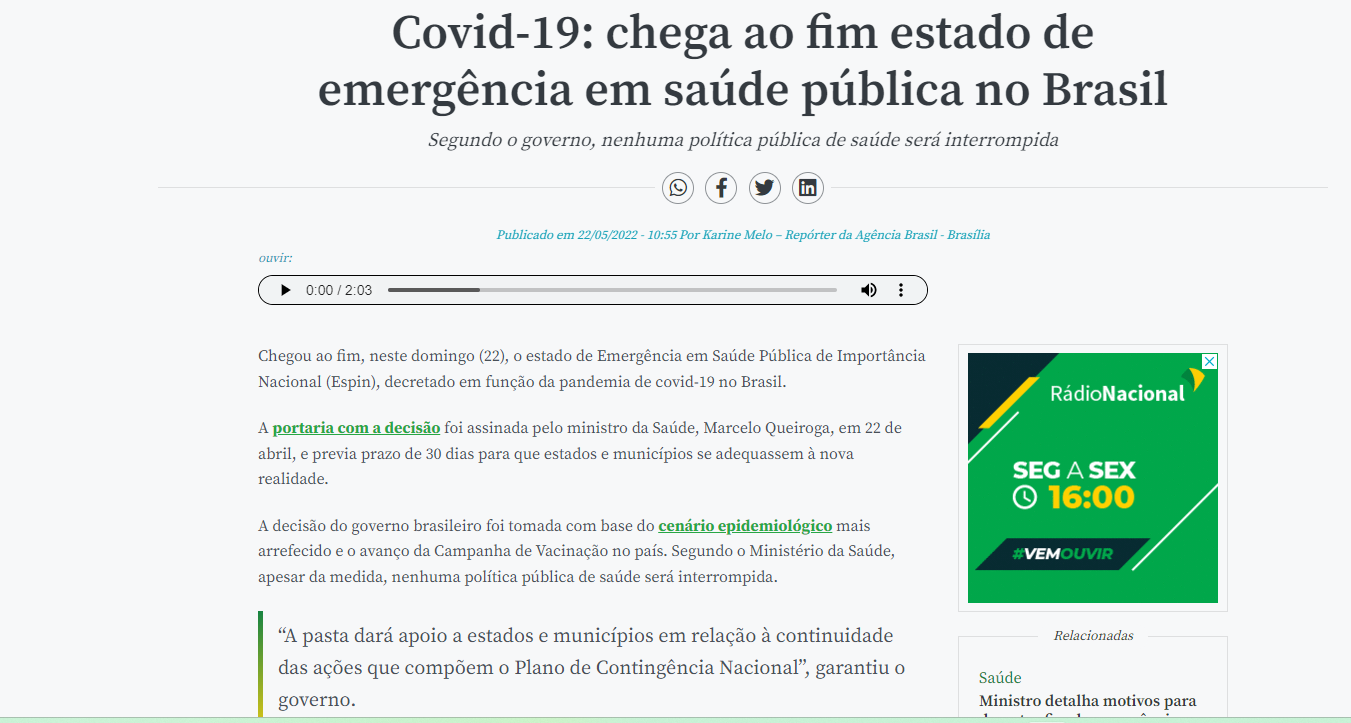


In [518]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-04           5201.71            47.57   
5            Sul 2023-07-03           5576.88            51.01   
11           Sul 2023-07-02           6054.74            55.38   
13           Sul 2023-07-01           6667.69            60.98   
19           Sul 2023-06-30           7526.90            72.06   
...          ...        ...               ...              ...   
27018   Nordeste 2005-01-05          11820.00            85.58   
27022   Nordeste 2005-01-04          11285.00            81.71   
27027   Nordeste 2005-01-03          10929.00            79.13   
27030   Nordeste 2005-01-02          10267.00            74.34   
27034   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                     5095.52                  46.60  20459.24    17992.88   
5                     5517.50                  50.4

In [519]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27036 entries, 1 to 27034
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27036 non-null  object        
 1   Data                    27036 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27036 non-null  float64       
 3   ENA_Bruta[%MLT]         27036 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27036 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27036 non-null  float64       
 6   EAR_max                 27036 non-null  float64       
 7   EAR[MWmes]              27036 non-null  float64       
 8   EAR[%max]               27036 non-null  float64       
 9   Carga_Diaria[MWmed]     27036 non-null  float64       
 10  CMO_semanal[R$/MWh]     27036 non-null  float64       
 11  CMO_leve[R$/MWh]        27036 non-null  float64       
 12  CMO_media[R$/MWh]       27036 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [520]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1752
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [521]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [522]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-04          23955.96            93.41   
4        Sudeste 2023-07-03          24380.40            95.07   
10       Sudeste 2023-07-02          24945.39            97.27   
12       Sudeste 2023-07-01          25529.46            99.55   
18       Sudeste 2023-06-30          26182.80            80.39   
...          ...        ...               ...              ...   
27016    Sudeste 2005-01-05          45324.00            90.05   
27020    Sudeste 2005-01-04          44388.00            88.19   
27025    Sudeste 2005-01-03          43314.00            86.06   
27031    Sudeste 2005-01-02          43352.00            86.13   
27032    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    23458.64                  91.48  204615.33   176390.34   
4                    24113.21                  94

## Visualizações Unimodais

### Histogramas

In [523]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

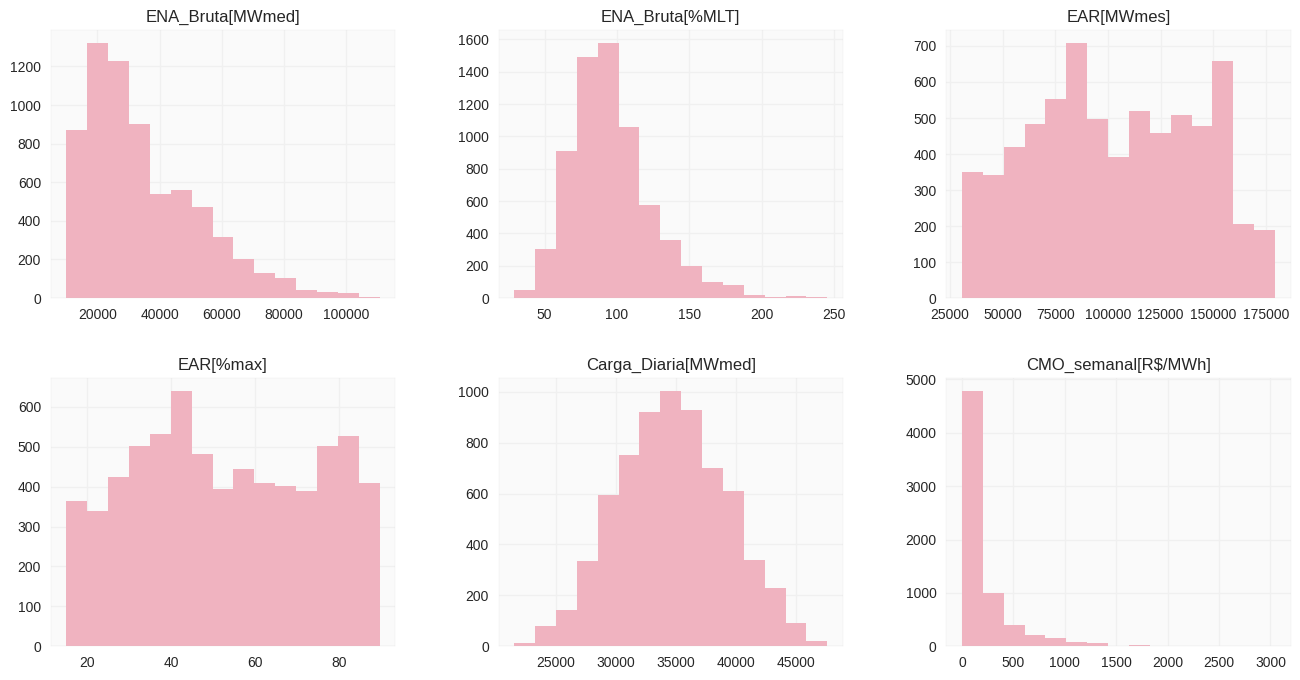

In [524]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

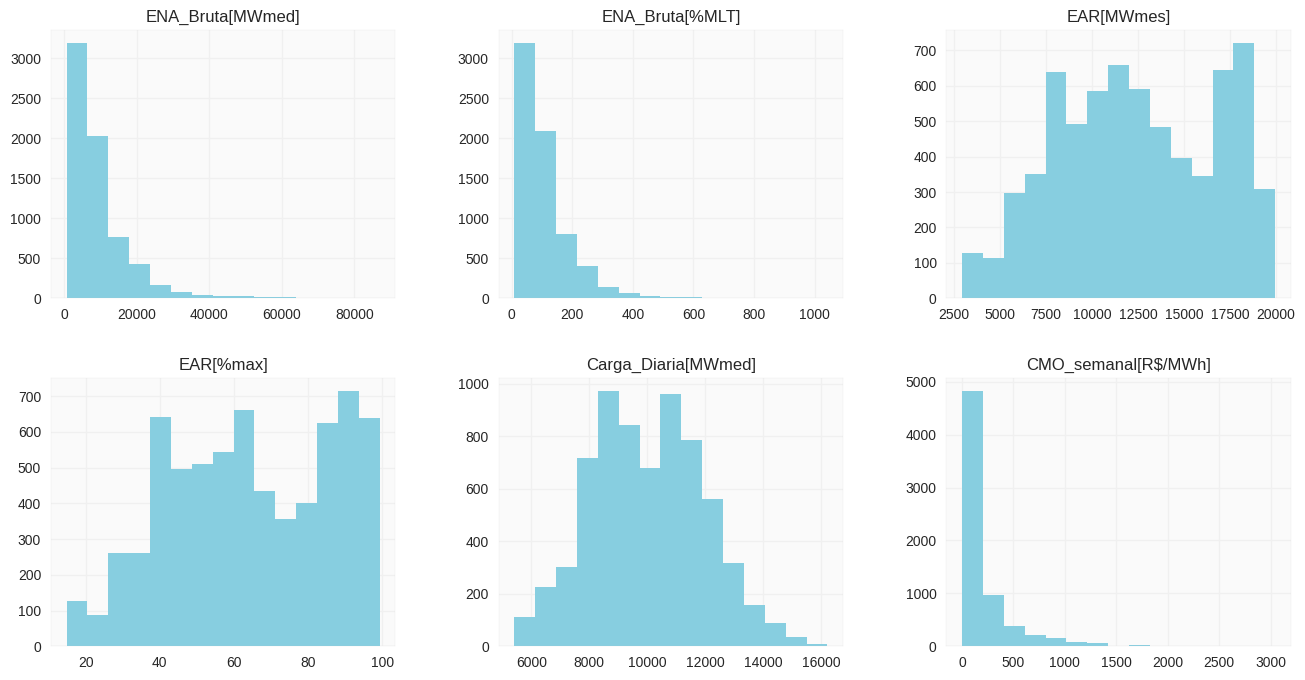

In [525]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

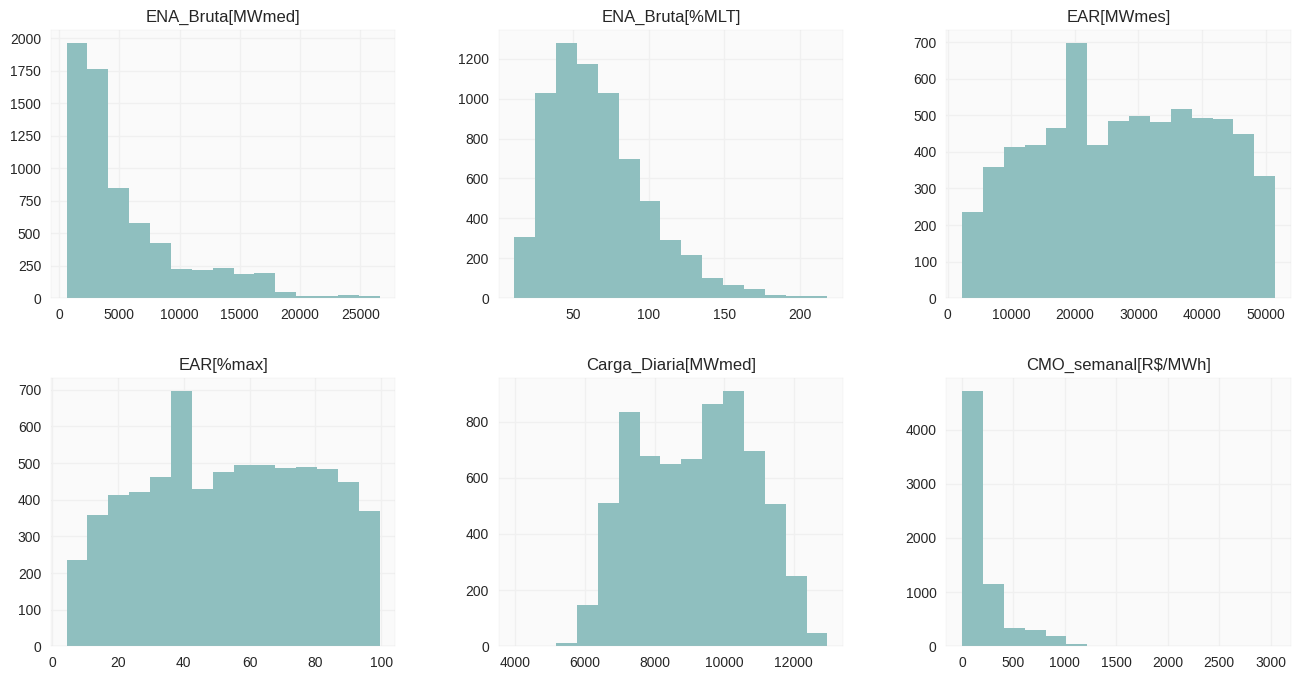

In [526]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

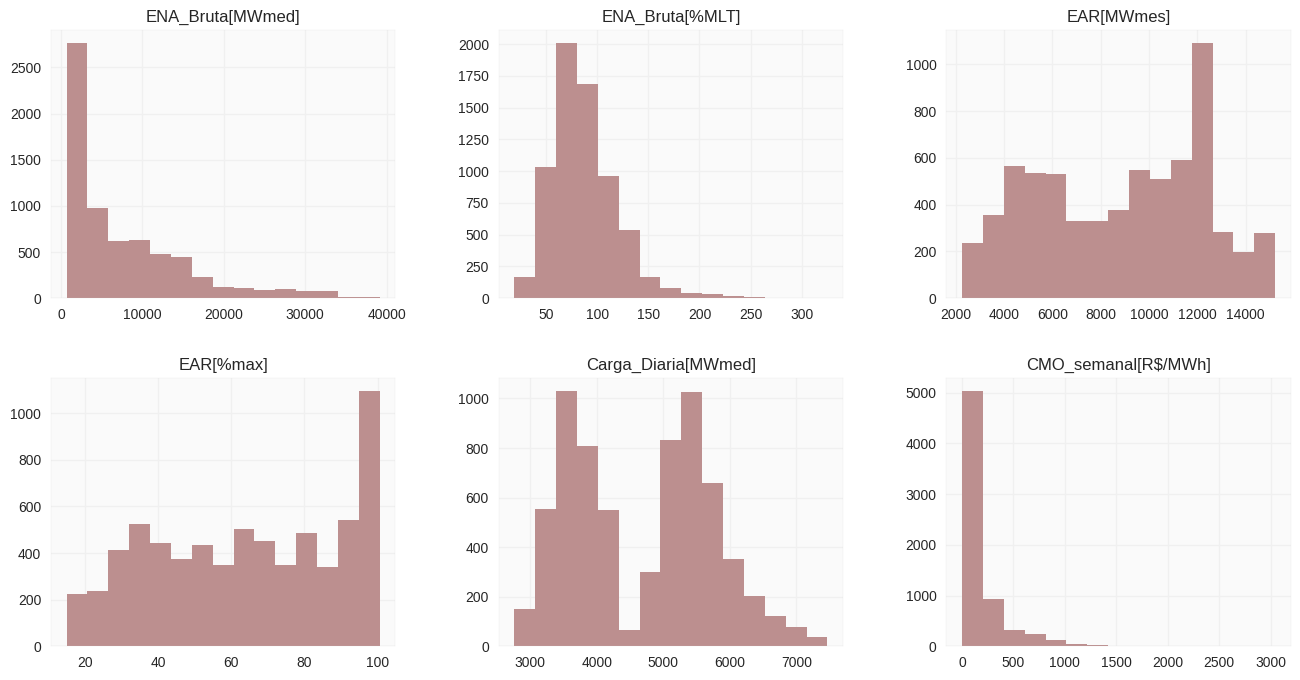

In [527]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

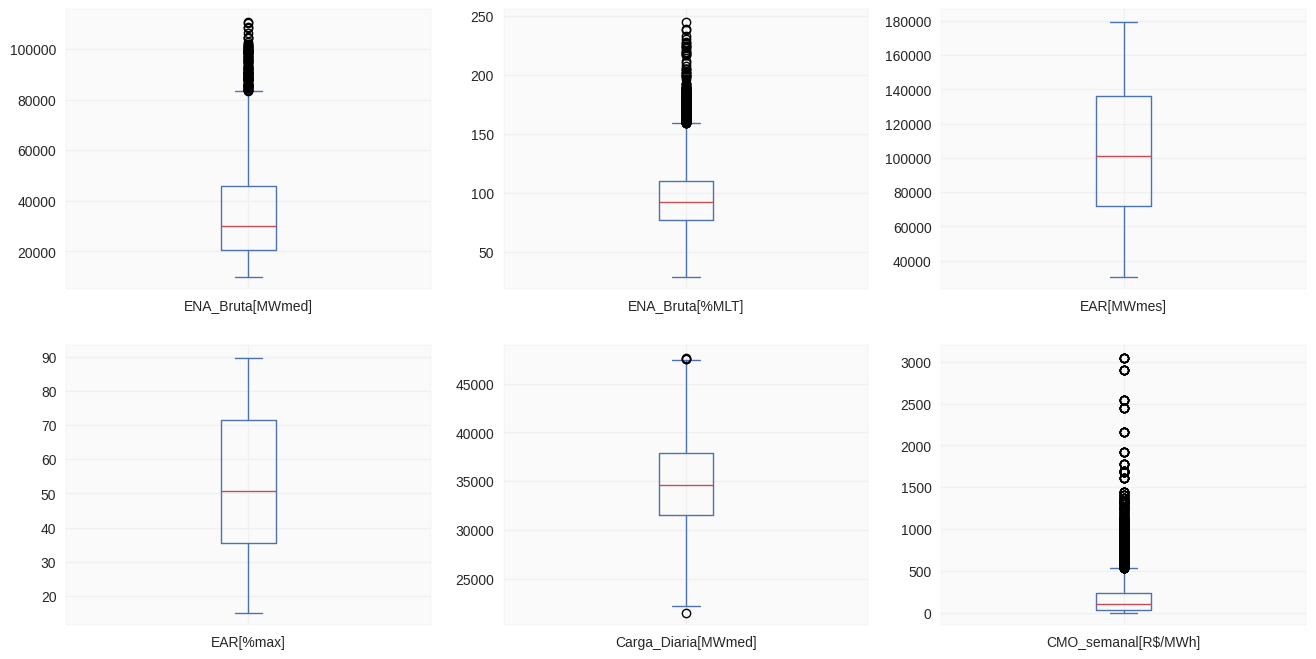

In [528]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

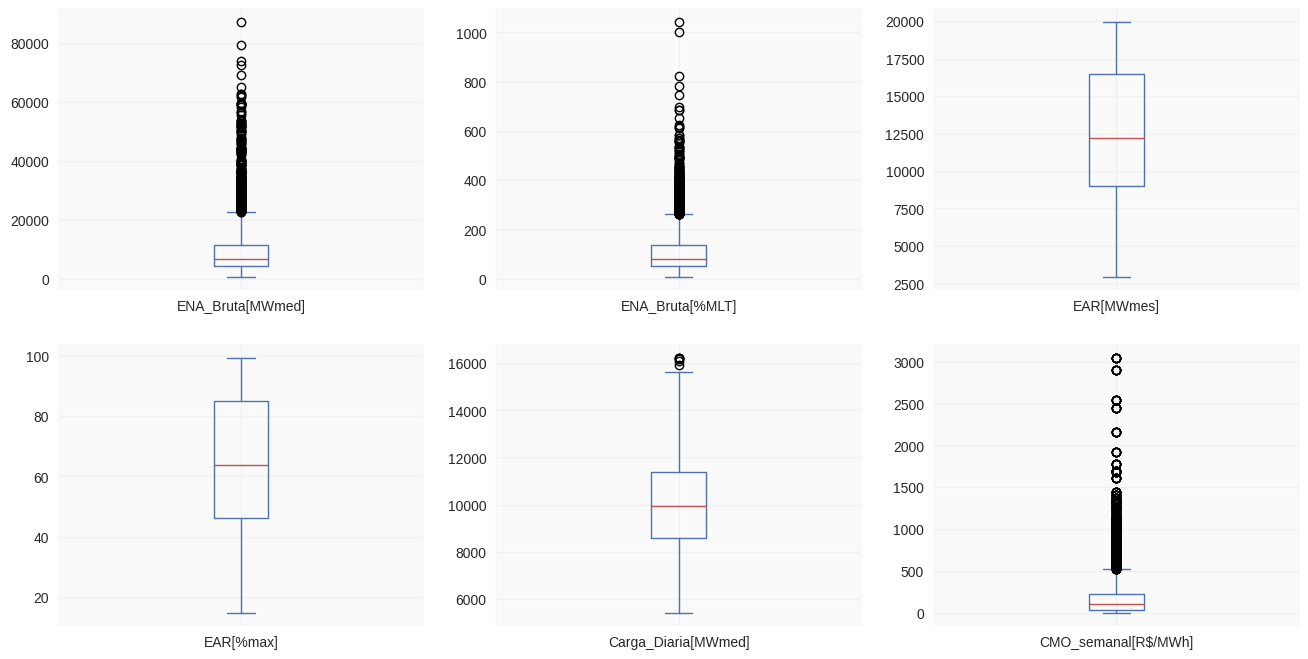

In [529]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

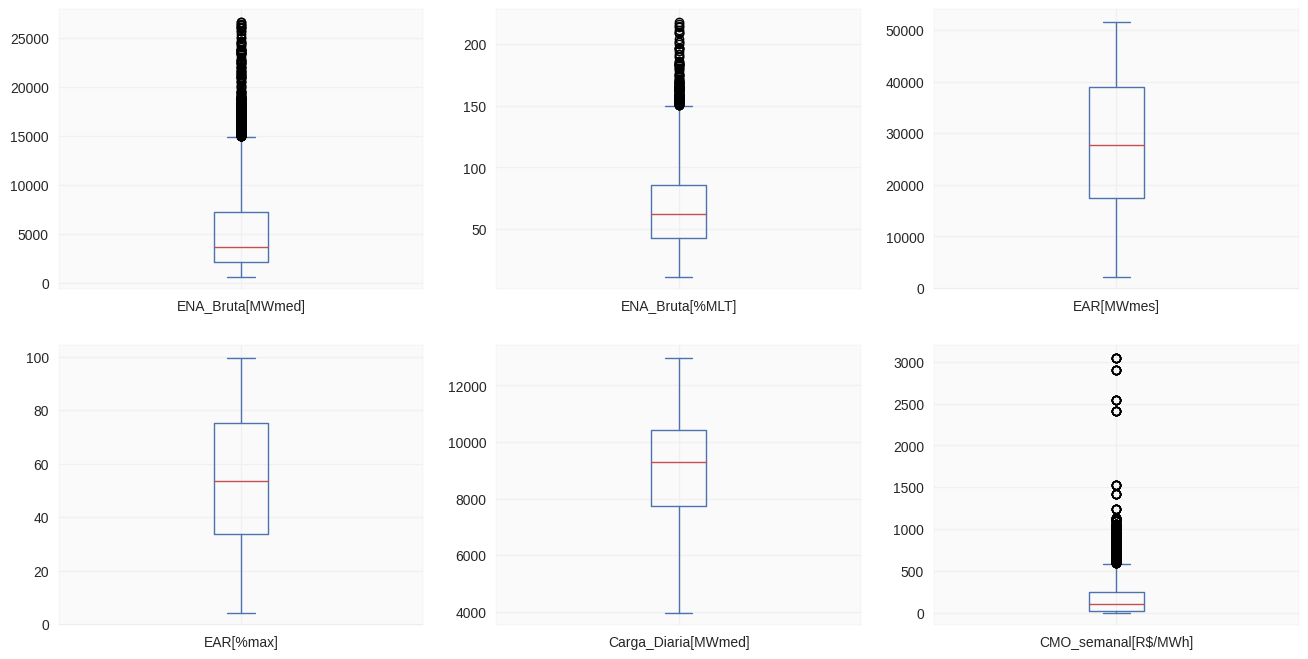

In [530]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

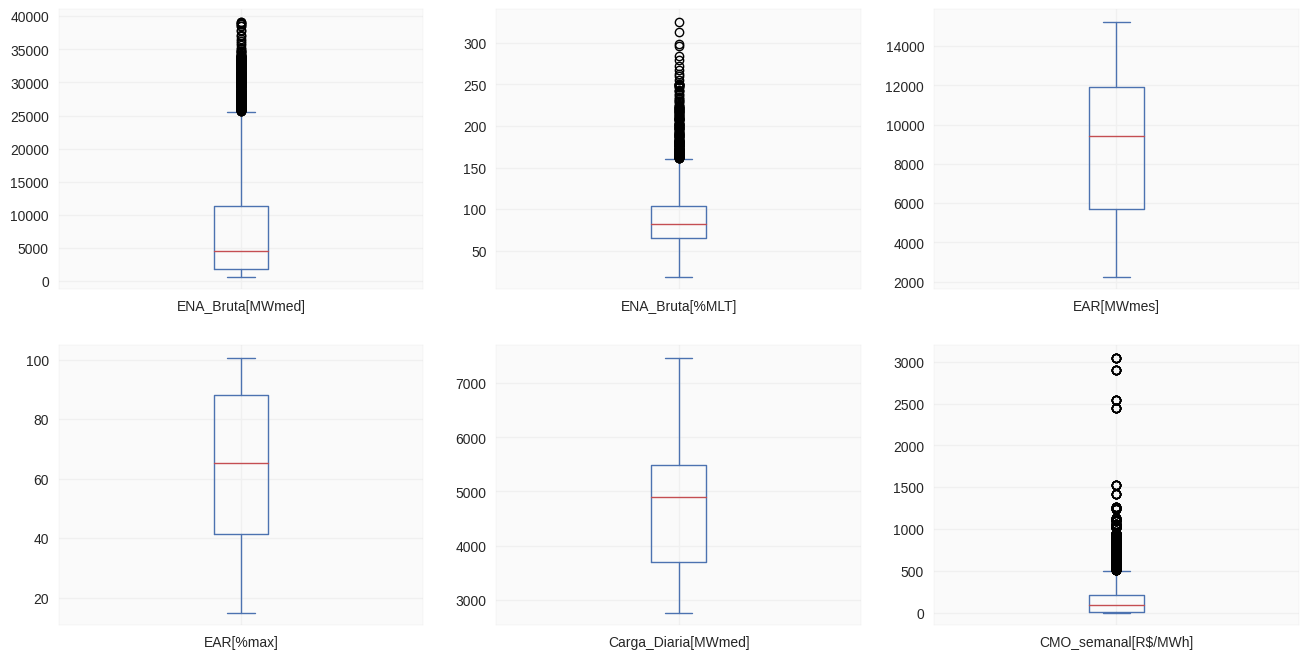

In [531]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






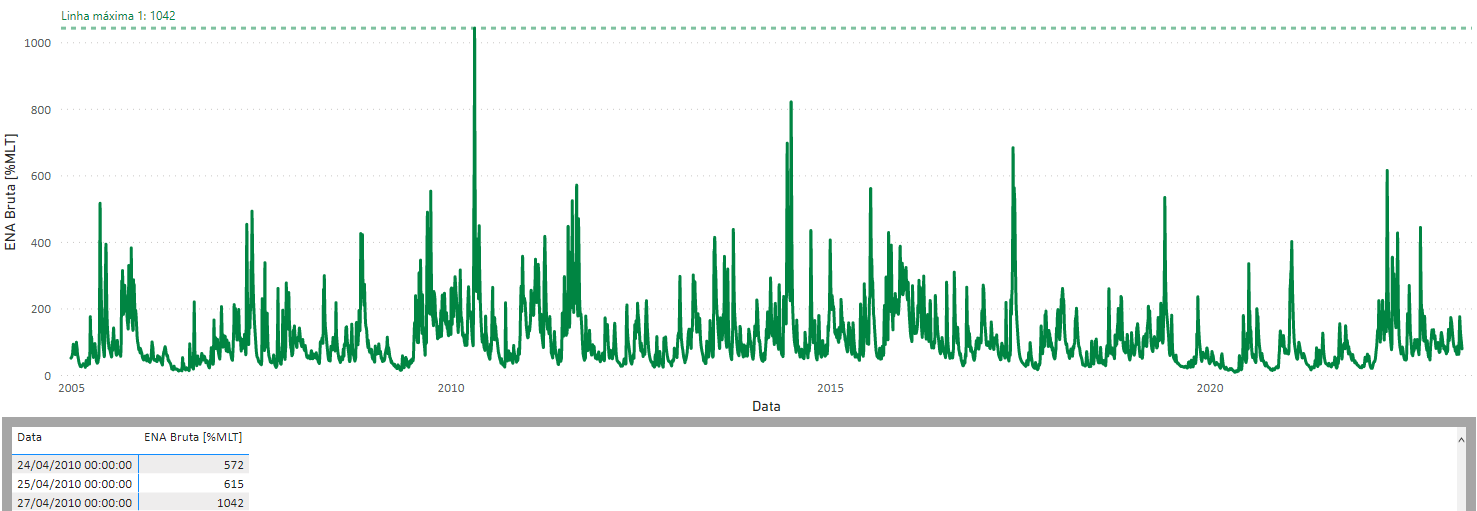
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

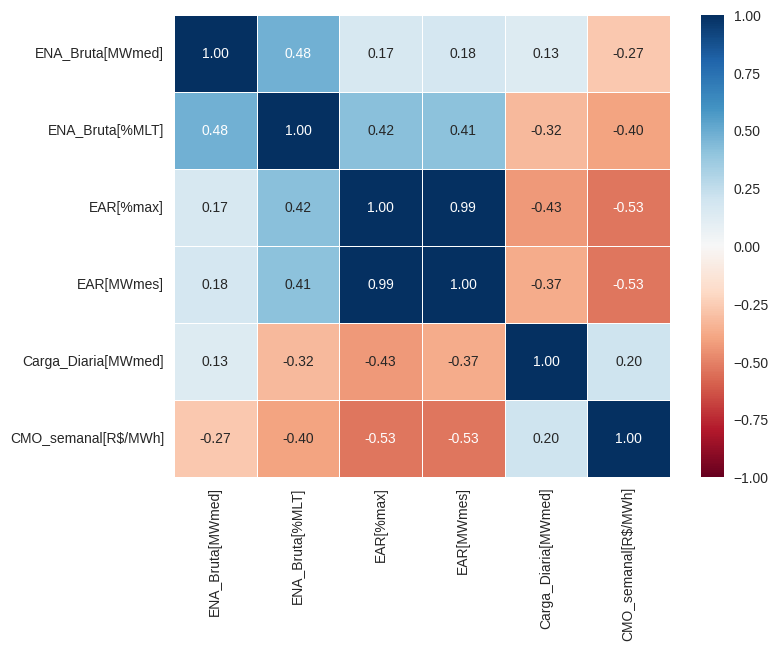

In [532]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

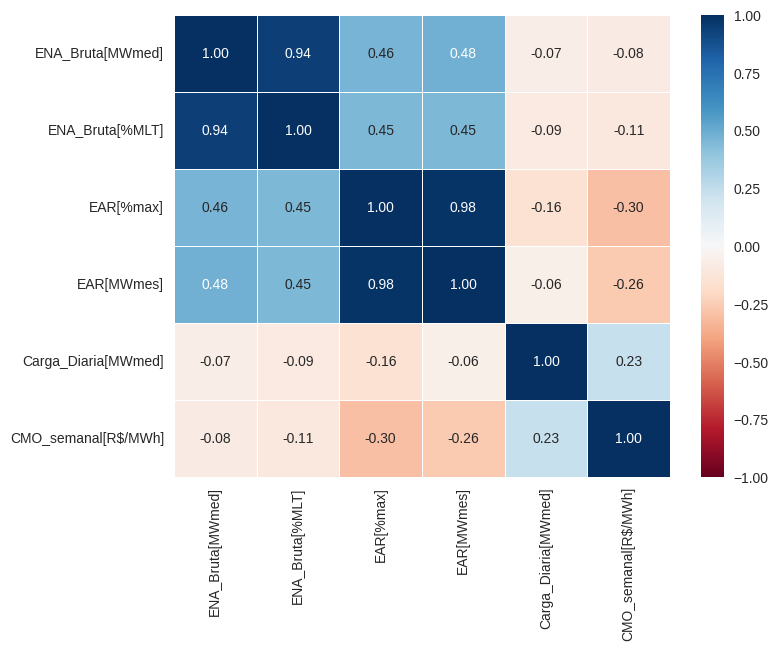

In [533]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

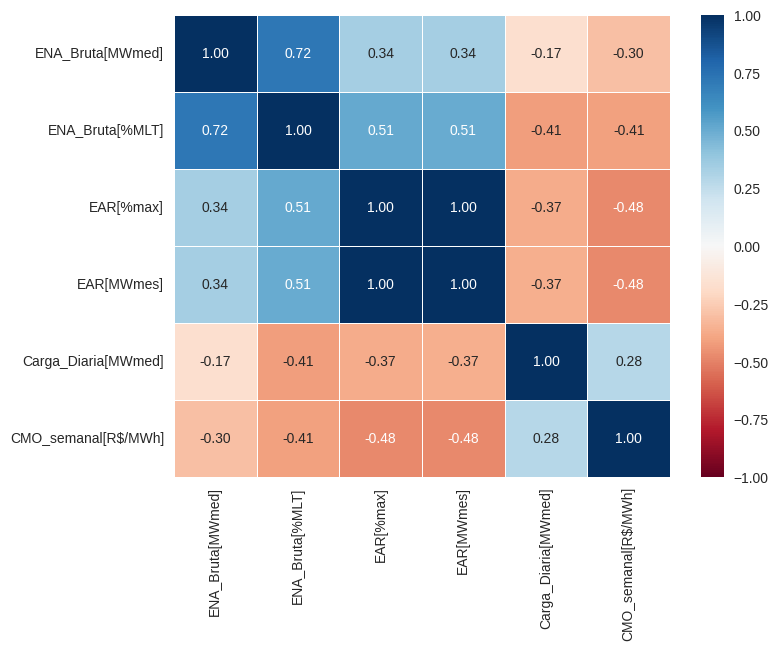

In [534]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

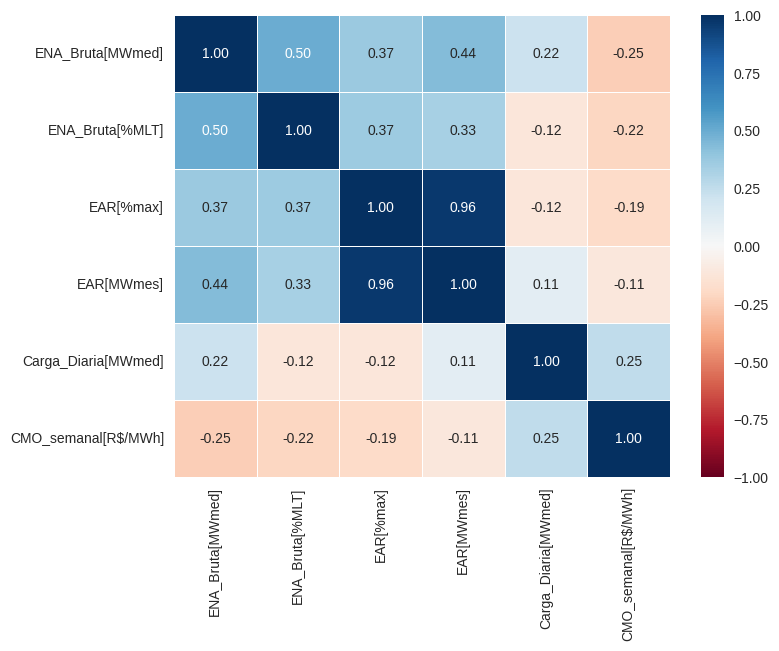

In [535]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional.

### Scatter Plot

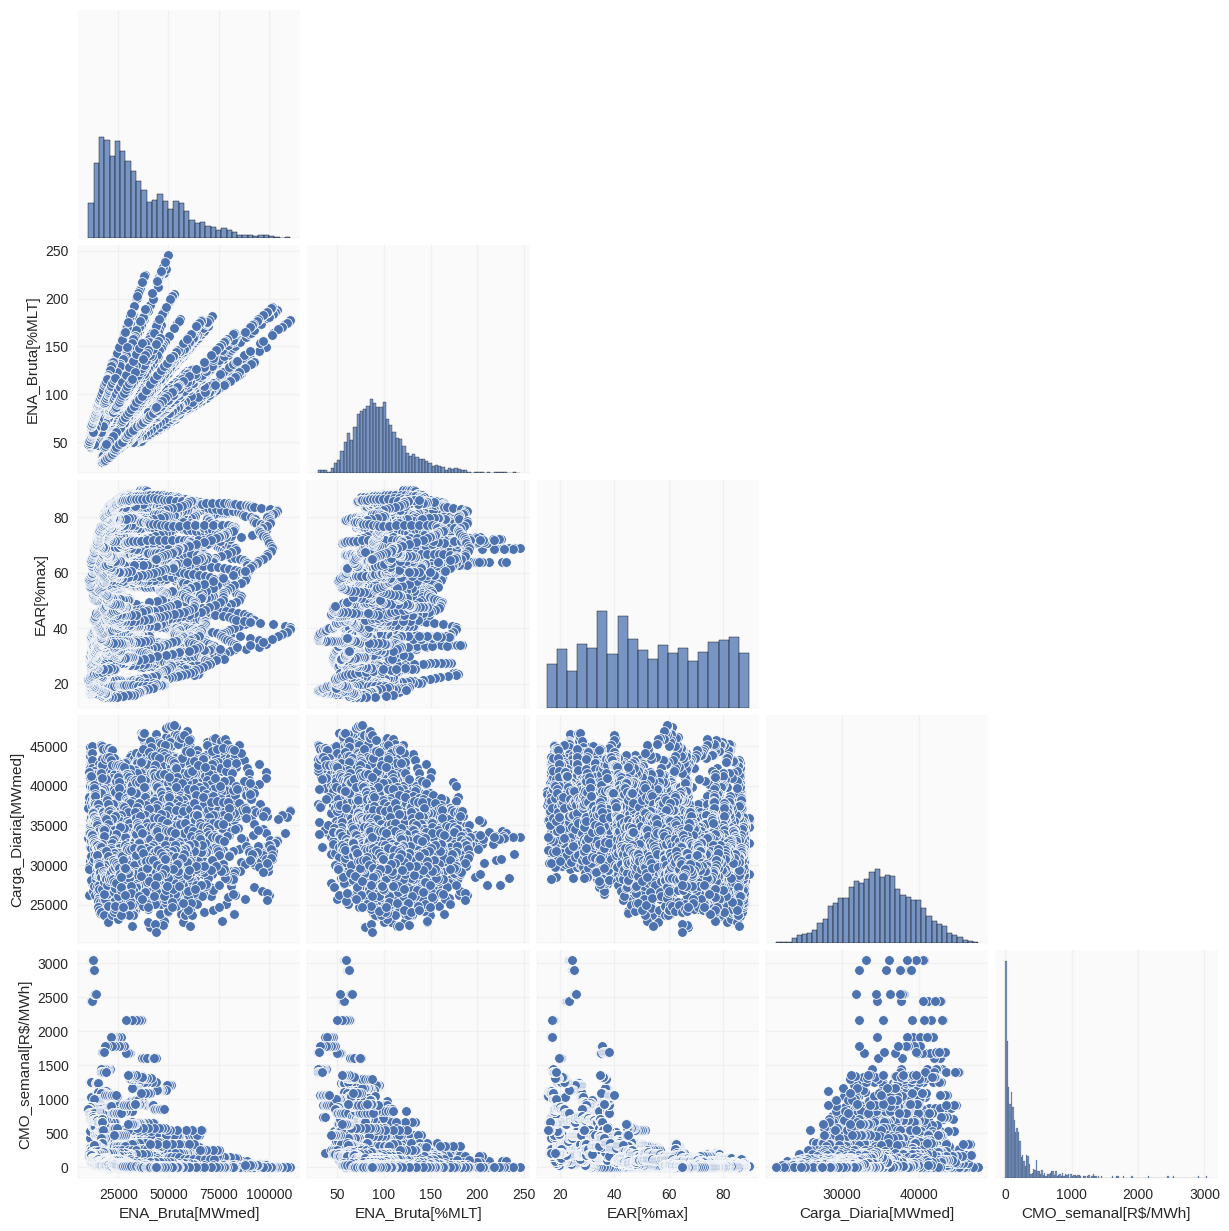

In [536]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

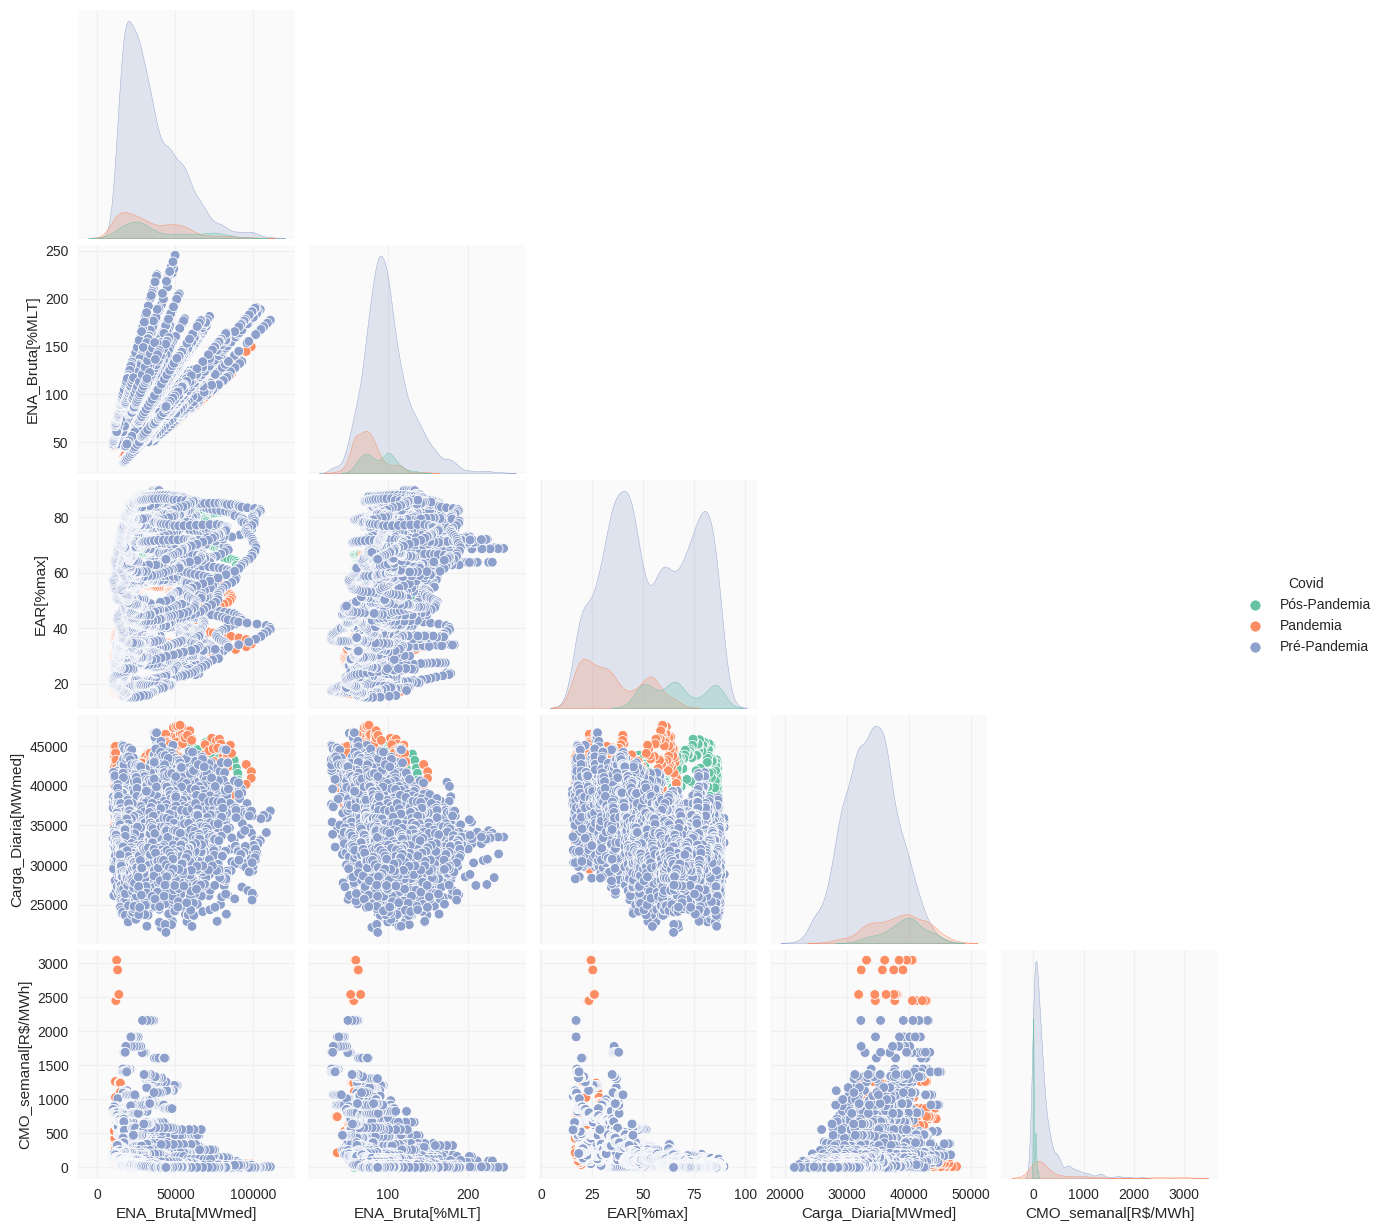

In [537]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

## Avaliações Temporais no Power BI

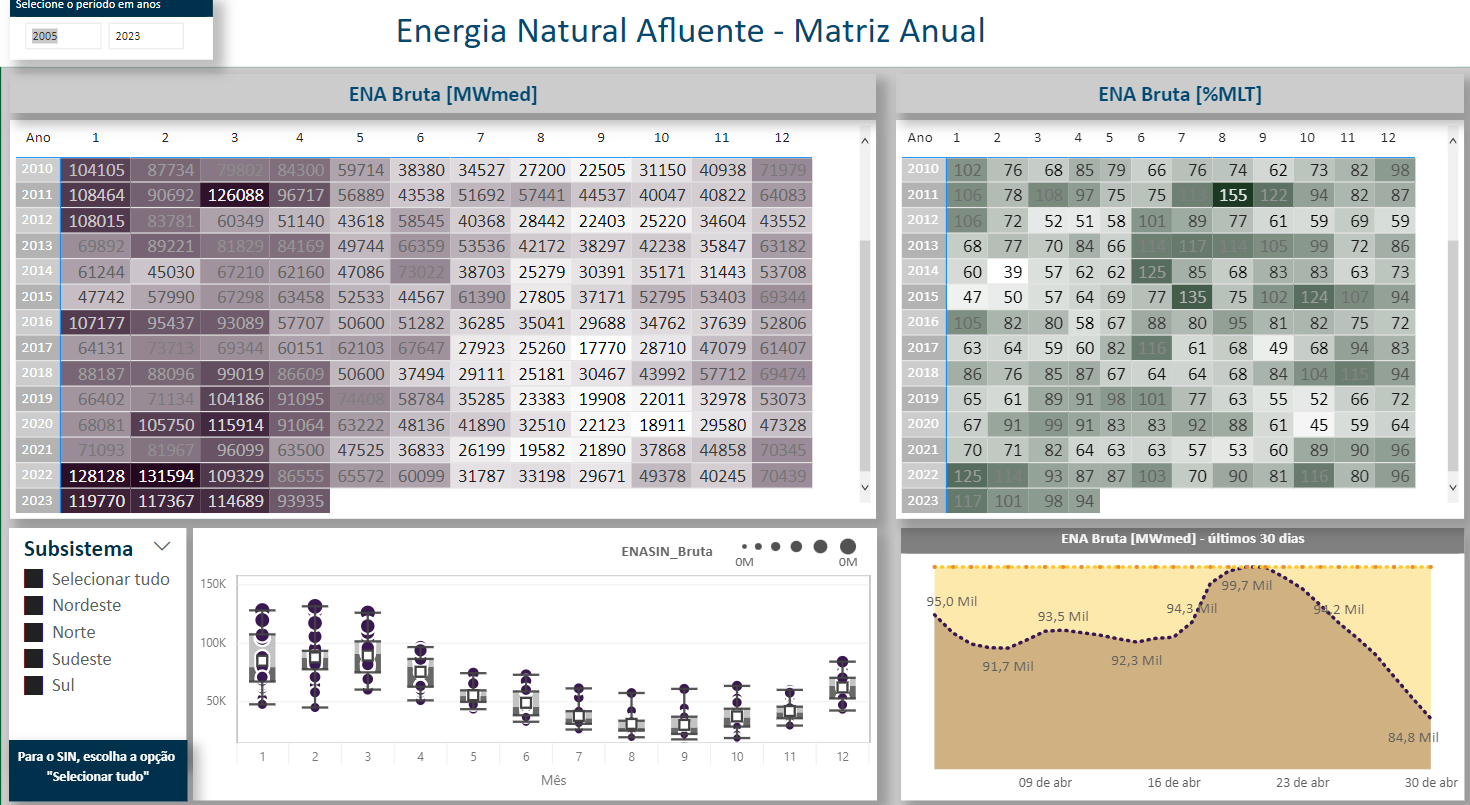

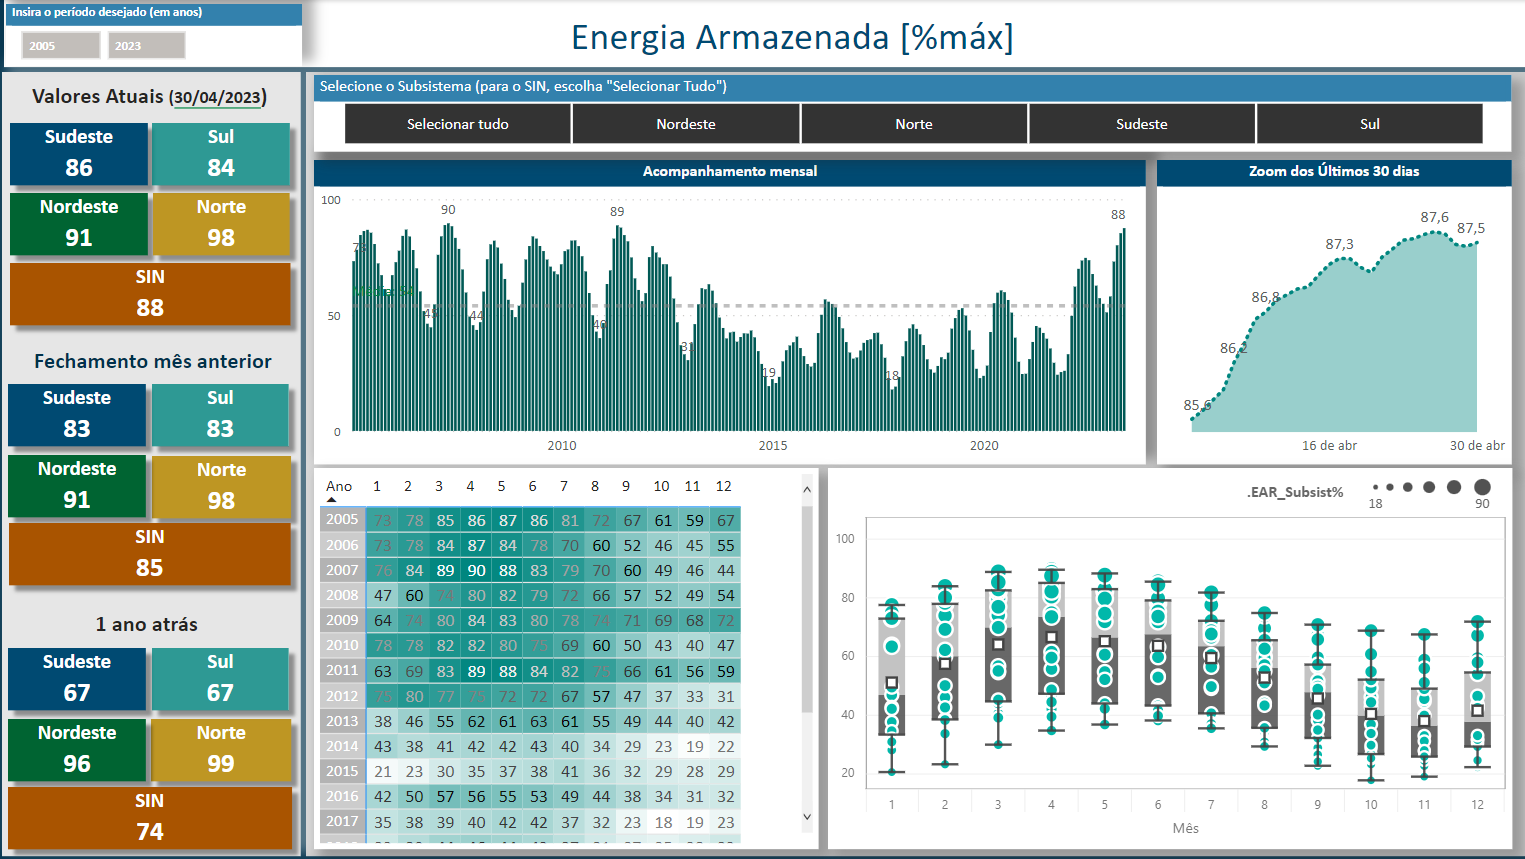

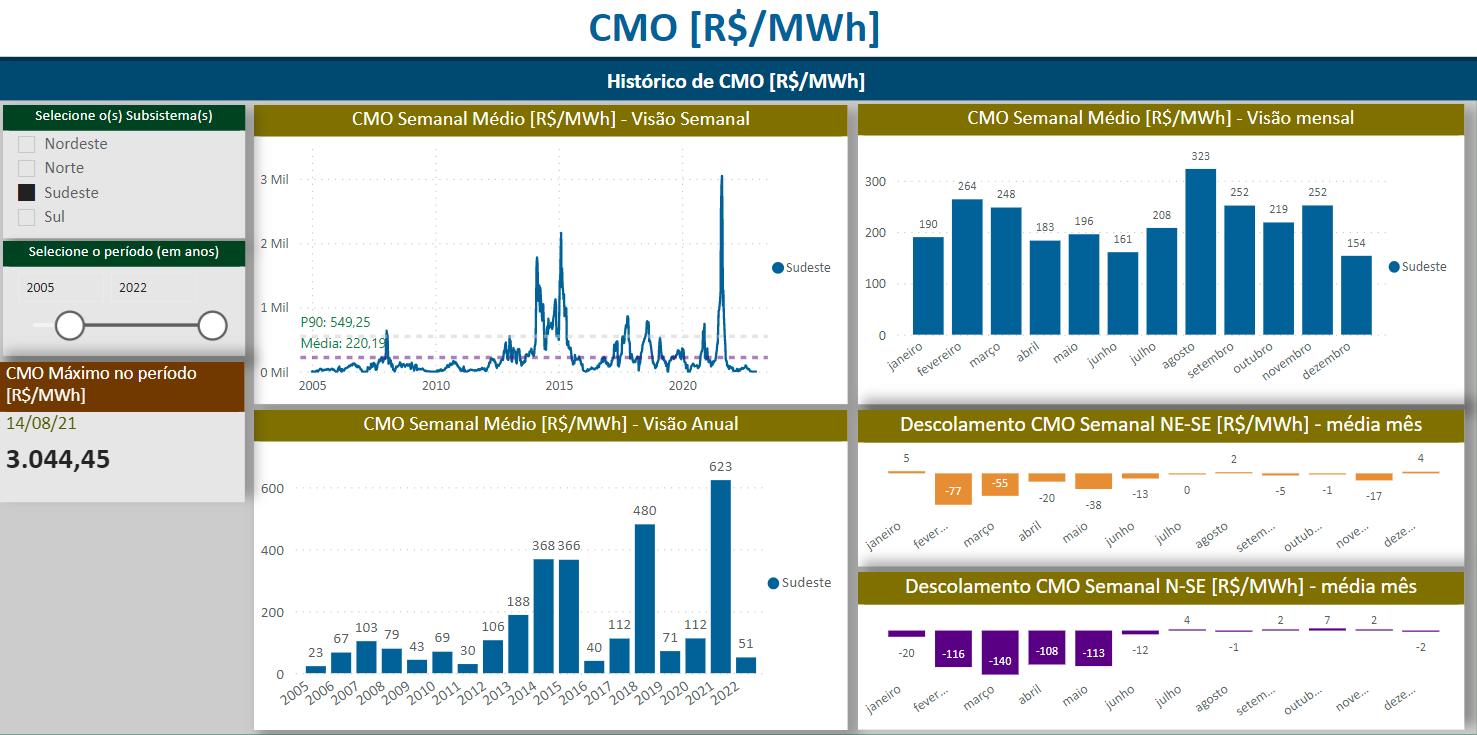

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que em 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante. Este aspecto não está explícito pelos dados do presente trabalho mas, em etapas futuras, faz-se pertinente a inclusão.


# **Seção IV: Pré-Processamento de Dados - Parte 2**


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [538]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]',]]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-04        Sul           5201.71            47.57   
5  2023-07-03        Sul           5576.88            51.01   
11 2023-07-02        Sul           6054.74            55.38   
13 2023-07-01        Sul           6667.69            60.98   
19 2023-06-30        Sul           7526.90            72.06   
21 2023-06-29        Sul           8970.55            85.88   
25 2023-06-28        Sul          10489.10           100.42   
29 2023-06-27        Sul          12598.97           120.62   
35 2023-06-26        Sul          15482.10           148.22   
37 2023-06-25        Sul          18803.26           180.01   
41 2023-06-24        Sul          19878.12           190.30   
45 2023-06-23        Sul          15157.86           145.11   
50 2023-06-22        Sul           8641.40            82.73   
53 2023-06-21        Sul           9164.72            87.74   
57 2023-06-20        Sul          10203.93            97.69   
61 2023-06-19        Sul          11749.27           112.48   
67 2023-06-18        Sul          13722.46           131.37   
69 2023-06-17        Sul          15497.13           148.36   
73 2023-06-16        Sul          14897.60           142.62   
77 2023-06-15        Sul           9175.31            87.84   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  5095.52                  46.60  20459.24      87.94   
5                  5517.50                  50.46  20459.24      87.88   
11                 5880.91                  53.79  20459.24      88.35   
13                 6604.06                  60.40  20459.24      88.42   
19                 7425.39                  71.09  20459.24      88.33   
21                 8175.37                  78.27  20459.24      88.69   
25                 7782.28                  74.50  20459.24      88.91   
29                 8769.78                  83.96  20459.24      88.70   
35                 8185.55                  78.36  20459.24      88.63   
37                 7885.57                  75.49  20459.24      88.85   
41                 9033.87                  86.49  20459.24      88.50   
45                 8709.36                  83.38  20459.24      87.32   
50                 7010.56                  67.12  20459.24      86.01   
53                 7115.49                  68.12  20459.24      85.75   
57                 8725.67                  83.54  20459.24      85.67   
61                 8196.03                  78.46  20459.24      85.12   
67                10547.37                 100.98  20459.24      84.89   
69                13598.06                 130.18  20459.24      84.11   
73                12618.48                 120.80  20459.24      82.90   
77                 8947.95                  85.66  20459.24      81.33   

    EAR[MWmes]  Carga_Diaria[MWmed]         Covid  CMO_semanal[R$/MWh]  
1     17992.88             12745.53  Pós-Pandemia                  0.0  
5     17980.25             12326.18  Pós-Pandemia                  0.0  
11    18076.37              9695.05  Pós-Pandemia                  0.0  
13    18090.41             10884.16  Pós-Pandemia                  0.0  
19    18072.36             12594.56  Pós-Pandemia                  0.0  
21    18145.95             12230.42  Pós-Pandemia                  0.0  
25    18189.47             12324.42  Pós-Pandemia                  0.0  
29    18148.24             12097.43  Pós-Pandemia                  0.0  
35    18133.57             11717.31  Pós-Pandemia                  0.0  
37    18177.75              8993.10  Pós-Pandemia                  0.0  
41    18106.51             10182.21  Pós-Pandemia                  0.0  
45    17864.58             12567.50  Pós-Pandemia                  0.0  
50    17597.21             12967.64  Pós-Pandemia                  0.0  
53    17544.79             12720.54  Pós-Pandemia                  0.0  
57    17528.37             12324.70

In [539]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
EAR[MWmes]                0
Carga_Diaria[MWmed]       0
Covid                     0
CMO_semanal[R$/MWh]       0
dtype: int64

In [540]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(27036, 12)
Sudeste:
(6759, 12)
Sul:
(6759, 12)
Nordeste:
(6759, 12)
Norte:
(6759, 12)


## Preparação para os Algoritmos de ML

A Normalização e a padronização são técnicas frequentemente aplicadas na etapa de preparação dos dados, com o objetivo de colocá-los em um intervalo de valores comuns. Não são técnicas obrigatórias para todos os algoritmos de Machine Learning mas podem impactar na acurácia do modelo a ser utilizado.

Alterando os dados da coluna 'Covid' de qualitativos (categóricos) para codificação ordinal, de modo que "Pré-Pandemia"=0; "Pandemia"=1 e "Pós-Pandemia"=2

In [541]:
# Armazenando os datasets com a coluna 'Covid' original
dados_pandemia=dados
dados_pandemia_SE=dados_SE
dados_pandemia_S=dados_S
dados_pandemia_NE=dados_NE
dados_pandemia_N=dados_N

In [542]:
# Aplicando Ordinal Encoding
dados['Covid']=dados['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_SE['Covid']=dados_SE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_S['Covid']=dados_S['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_NE['Covid']=dados_NE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_N['Covid']=dados_N['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-04        Sul           5201.71            47.57   
5  2023-07-03        Sul           5576.88            51.01   
11 2023-07-02        Sul           6054.74            55.38   
13 2023-07-01        Sul           6667.69            60.98   
19 2023-06-30        Sul           7526.90            72.06   
21 2023-06-29        Sul           8970.55            85.88   
25 2023-06-28        Sul          10489.10           100.42   
29 2023-06-27        Sul          12598.97           120.62   
35 2023-06-26        Sul          15482.10           148.22   
37 2023-06-25        Sul          18803.26           180.01   
41 2023-06-24        Sul          19878.12           190.30   
45 2023-06-23        Sul          15157.86           145.11   
50 2023-06-22        Sul           8641.40            82.73   
53 2023-06-21        Sul           9164.72            87.74   
57 2023-06-20        Sul          10203.93            97.69   
61 2023-06-19        Sul          11749.27           112.48   
67 2023-06-18        Sul          13722.46           131.37   
69 2023-06-17        Sul          15497.13           148.36   
73 2023-06-16        Sul          14897.60           142.62   
77 2023-06-15        Sul           9175.31            87.84   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                  5095.52                  46.60  20459.24      87.94   
5                  5517.50                  50.46  20459.24      87.88   
11                 5880.91                  53.79  20459.24      88.35   
13                 6604.06                  60.40  20459.24      88.42   
19                 7425.39                  71.09  20459.24      88.33   
21                 8175.37                  78.27  20459.24      88.69   
25                 7782.28                  74.50  20459.24      88.91   
29                 8769.78                  83.96  20459.24      88.70   
35                 8185.55                  78.36  20459.24      88.63   
37                 7885.57                  75.49  20459.24      88.85   
41                 9033.87                  86.49  20459.24      88.50   
45                 8709.36                  83.38  20459.24      87.32   
50                 7010.56                  67.12  20459.24      86.01   
53                 7115.49                  68.12  20459.24      85.75   
57                 8725.67                  83.54  20459.24      85.67   
61                 8196.03                  78.46  20459.24      85.12   
67                10547.37                 100.98  20459.24      84.89   
69                13598.06                 130.18  20459.24      84.11   
73                12618.48                 120.80  20459.24      82.90   
77                 8947.95                  85.66  20459.24      81.33   

    EAR[MWmes]  Carga_Diaria[MWmed]  Covid  CMO_semanal[R$/MWh]  
1     17992.88             12745.53      2                  0.0  
5     17980.25             12326.18      2                  0.0  
11    18076.37              9695.05      2                  0.0  
13    18090.41             10884.16      2                  0.0  
19    18072.36             12594.56      2                  0.0  
21    18145.95             12230.42      2                  0.0  
25    18189.47             12324.42      2                  0.0  
29    18148.24             12097.43      2                  0.0  
35    18133.57             11717.31      2                  0.0  
37    18177.75              8993.10      2                  0.0  
41    18106.51             10182.21      2                  0.0  
45    17864.58             12567.50      2                  0.0  
50    17597.21             12967.64      2                  0.0  
53    17544.79             12720.54      2                  0.0  
57    17528.37             12324.70      2                  0.0  
61    17414.84             11979.16      2                  0.0  
67    17

In [560]:
# Adicionando uma coluna referente ao dia da semana correspondente à data

dados=dados.assign(Dia_da_semana=1)
dados=dados.assign(Numero_da_semana=100000)
dados=dados.sort_values('Data',ascending=True)
for i in range(0,comp_dados):
    dados['Dia_da_semana'][i]=dados['Data'][i].weekday() #Por esta lógica, as segundas recebem o índice 0  e os domingos, 6
# Para retratar semanas operativas, que vão do sábado à sexta da semana seguinte, é interessante que os sábados correspondam ao 0, domingos ao 1...sexta-feira corresponda a 6:
    if dados['Dia_da_semana'][i]<5:   #(de segunda a sexta-feira)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]+2
       dados['Numero_da_semana'][i]=dados['Data'][i].week
    else:    #(sábado e domingo)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]-5
       dados['Numero_da_semana'][i]=dados['Data'][i].week+1
print(dados)


            Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
27032 2005-01-01    Sudeste          43952.00            87.32   
27035 2005-01-01      Norte           4157.00            50.75   
27033 2005-01-01        Sul           2812.00            50.65   
27034 2005-01-01   Nordeste          10222.00            74.01   
27028 2005-01-02        Sul           2814.00            50.69   
...          ...        ...               ...              ...   
5     2023-07-03        Sul           5576.88            51.01   
3     2023-07-04      Norte           5264.08           100.06   
0     2023-07-04    Sudeste          23955.96            93.41   
2     2023-07-04   Nordeste           2255.81            59.76   
1     2023-07-04        Sul           5201.71            47.57   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[%max]  \
27032                40017.00                  79.51  177852.00      64.78   
27035                 4157.00                  50.7

A variável que pretendemos predizer é o CMO Semanal Médio. Para tal, dividiremos nosso dataset por cada um dos subsistemas, considerando os subconjuntos de treino, teste e validação.

Por se tratar de uma variável numérica, contínua, utilizaremos algoritmos de Machine Learning destinados a problemas de regressão.

In [ ]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# A variável de interesse é o CMO Semanal Médio [R$/MWh]
# A data não será considerada

# SIN
array=dados.values
X= array[:,1:11] # atributos
y=array[:,11] # classe (target)
# Sudeste
X_SE= dados_SE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_SE=dados_SE.values[:,11]  # classe (target)
# Sul
X_S= dados_S.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_S=dados_S.values[:,11]  # classe (target)
# Nordeste
X_NE= dados_NE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_NE=dados_NE.values[:,11]  # classe (target)
# Norte
X_N= dados_N.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_N=dados_N.values[:,11]  # classe (target)

Neste momento, realizaremos a análise apenas para o subsistema Sudeste, uma vez que responde por mais de 60% da carga do Sistema Interligado Nacional e por mais de 70% da capacidade de armazenamento. Portanto, será realizada etapa de normalização e padronização dos dados quantitativos do dataset dados_SE

### Normalização dos Dados

In [ ]:
# Normalizando os dados
rescaledX_norm = MinMaxScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Normalizados (não inclui a coluna class): \n\n", rescaledX_norm)

Dados Originais: 

 [[Timestamp('2023-05-02 00:00:00') 'Sudeste' 48473.26 ... 2 0.0 2]
 [Timestamp('2023-05-01 00:00:00') 'Sudeste' 49685.99 ... 2 0.0 2]
 [Timestamp('2023-04-30 00:00:00') 'Sudeste' 51014.51 ... 2 0.0 2]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 0 0.0 0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 0 0.0 0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 0 0.0 0]]

Dados Normalizados (não inclui a coluna class): 

 [[0.38173198 0.42759291 0.34532354 ... 0.95355705 0.73551536 1.        ]
 [0.39376876 0.44166242 0.29913266 ... 0.95449664 0.5116954  1.        ]
 [0.4069548  0.29675568 0.30133153 ... 0.95422819 0.49998257 1.        ]
 ...
 [0.33052446 0.2638034  0.43522669 ... 0.66926174 0.22828458 0.        ]
 [0.33090162 0.26412737 0.40982741 ... 0.66818792 0.03839024 0.        ]
 [0.33685684 0.26963484 0.40314271 ... 0.66657718 0.         0.        ]]


### Padronização dos Dados

In [ ]:
# Padronizando os dados
rescaledX_padr = StandardScaler().fit_transform(X_SE)

# Exibindo os dados transformados
print("Dados Originais: \n\n", dados_SE.values)
print("\nDados Padronizados (não inclui a coluna class): \n\n", rescaledX_padr)

Dados Originais: 

 [[Timestamp('2023-05-02 00:00:00') 'Sudeste' 48473.26 ... 2 0.0 2]
 [Timestamp('2023-05-01 00:00:00') 'Sudeste' 49685.99 ... 2 0.0 2]
 [Timestamp('2023-04-30 00:00:00') 'Sudeste' 51014.51 ... 2 0.0 2]
 ...
 [Timestamp('2005-01-03 00:00:00') 'Sudeste' 43314.0 ... 0 0.0 0]
 [Timestamp('2005-01-02 00:00:00') 'Sudeste' 43352.0 ... 0 0.0 0]
 [Timestamp('2005-01-01 00:00:00') 'Sudeste' 43952.0 ... 0 0.0 0]]

Dados Padronizados (não inclui a coluna class): 

 [[ 0.74323101  0.88520847  0.26457726 ...  1.62997655  1.33783488
   3.3075294 ]
 [ 0.8093511   0.99132178  0.02319005 ...  1.63335269  0.04668885
   3.3075294 ]
 [ 0.88178425 -0.10157552  0.03468102 ...  1.63238808 -0.02087876
   3.3075294 ]
 ...
 [ 0.46193943 -0.35010406  0.73439876 ...  0.60845383 -1.58821796
  -0.4231565 ]
 [ 0.46401125 -0.34766067  0.60166561 ...  0.60459539 -2.68365792
  -0.4231565 ]
 [ 0.49672427 -0.30612289  0.56673229 ...  0.59880773 -2.90511898
  -0.4231565 ]]


In [ ]:
# Dividindo os dados nos subconjuntos de treino e teste (20% dos dados serão utilizados para teste)
X_train,X_test,y_train,y_test= train_test_split(X_SE, y_SE, test_size=0.20, random_state=7)

# Criando os folds para validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

# **Seção V: Conclusão**

O presente trabalho teve como objetivo a obtenção, tratamento e análise dos dados históricos de Energia Natural Afluente, Energia Armazenada, Demanda Elétrica e Custo Marginal da Operação, a partir dos dados diários por subsistema publicados pelo Operador Nacional do Sistema Elétrico. Puderam-se observar os comportamentos das referidas grandezas no período de 2005 a abril/2023, tanto ao longo do tempo, quanto em termos de distribuição (unimodal). Além disso, também foi possível avaliar as correlações entre as mesmas.

As etapas até aqui realizadas visam a, em um próximo momento, possibilitar a elaboração de algoritmos de aprendizagem de máquina no intuito de levar a predições/prescrições sobre expectativas de Custo Marginal da Operação frente a cenários futuros de ENA, EArm e Carga, considerando o histórico das mesmas e do próprio CMO.